<a href="https://colab.research.google.com/github/PragnyaYS/Intrusion-Detection-Model-Training/blob/main/fda_a3_25533252_Pragnya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing libraries
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, KFold

# **Importing the training dataset**

In [ ]:
train_iot = "train_IoT_Intrusion_Detection.csv"
iotData = pd.read_csv(train_iot)

In [ ]:
iotData.head()

,Unnamed: 0,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,3233,0.000000,0.00,46.53,63.36,22.666768,22.666768,0.0,0,0,...,3.472171,572.82,83647298.08,9.5,33.975197,4.949597,408.368004,0.03,141.55,Mirai-greip_flood
1,912,0.000000,0.00,45.16,71.64,30.076685,30.076685,0.0,0,0,...,40.071279,557.68,83651098.76,9.5,33.204502,56.724539,8981.817205,0.18,141.55,Mirai-greip_flood
2,7005,0.155276,41.75,41.26,70.45,27595.714830,27595.714830,0.0,0,0,...,102.663423,499.11,83581706.66,9.5,31.277104,145.292553,20348.252270,0.61,141.55,Mirai-greip_flood
3,13669,0.000000,0.00,47.00,64.00,5.858490,5.858490,0.0,0,0,...,0.000000,578.00,83581699.68,9.5,34.000000,0.000000,0.000000,0.00,141.55,Mirai-greip_flood
4,7895,0.000000,0.00,47.00,64.00,53.647950,53.647950,0.0,0,0,...,0.000000,578.00,83573865.37,9.5,34.000000,0.000000,0.000000,0.00,141.55,Mirai-greip_flood


## **Visualizing the dataset**

In [ ]:
# Check basic structure
print(iotData.describe())
print(iotData.isnull().sum())

         Unnamed: 0  flow_duration  Header_Length  Protocol Type  \
count  15600.000000   15600.000000   1.560000e+04   15600.000000   
mean    9705.825064      58.735890   2.384301e+04      40.488088   
std     5631.424944    1056.987013   1.818260e+05      13.525687   
min        0.000000       0.000000   0.000000e+00       1.570000   
25%     4804.500000       0.000000   0.000000e+00      44.890000   
50%     9673.500000       0.000000   7.800000e-01      46.530000   
75%    14587.500000       0.029531   1.561250e+01      47.000000   
max    19500.000000   51182.926770   8.879658e+06      47.000000   

           Duration          Rate         Srate    Drate  fin_flag_number  \
count  15600.000000  1.560000e+04  1.560000e+04  15600.0     15600.000000   
mean      69.431394  9.517368e+03  9.517368e+03      0.0         0.000256   
std       19.839338  1.040724e+05  1.040724e+05      0.0         0.016011   
min        2.000000  0.000000e+00  0.000000e+00      0.0         0.000000   
25

# **Data Pre-processing & splitting**

## **Visualizing the data distribution**

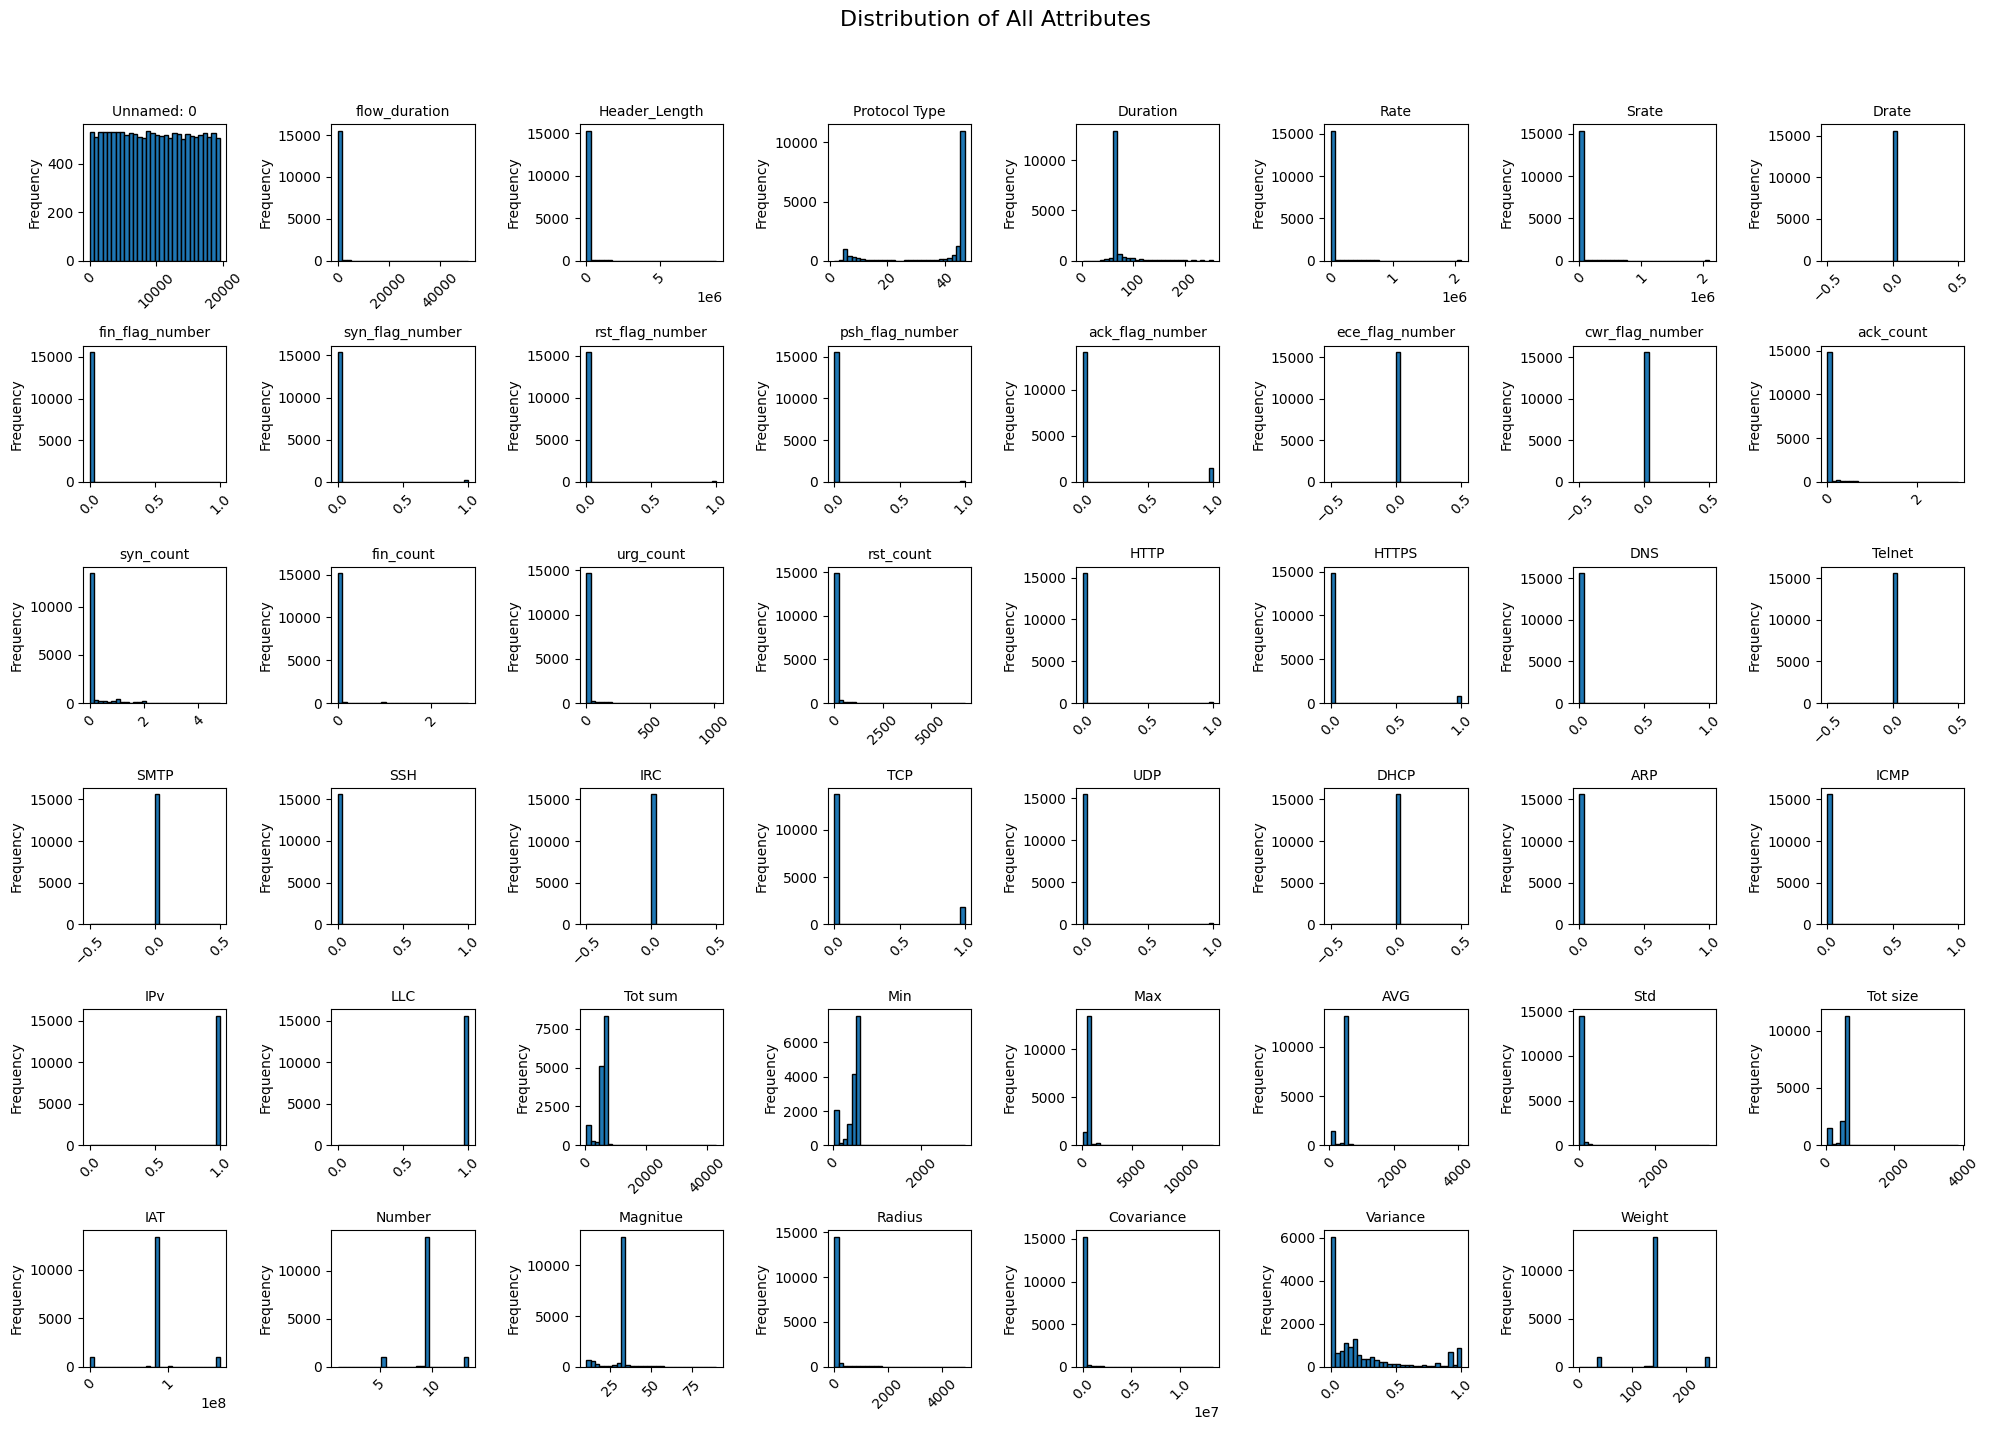

In [ ]:
#Excluding the Label column as it is a categorical attribute (string)
# Select only numeric columns
numeric_data = iotData.select_dtypes(include=['number'])

# Set up a grid of subplots for each attribute (6 rows x 8 columns for 48 attributes)
fig, axes = plt.subplots(6, 8, figsize=(20, 15))
fig.suptitle("Distribution of All Attributes", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each numeric column and create a histogram in its subplot
for i, col in enumerate(numeric_data.columns):
    # Plotting the distribution of each attribute
    numeric_data[col].plot(kind='hist', ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Remove any empty subplots (if there are less than 48)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **Visualizing Outliers**

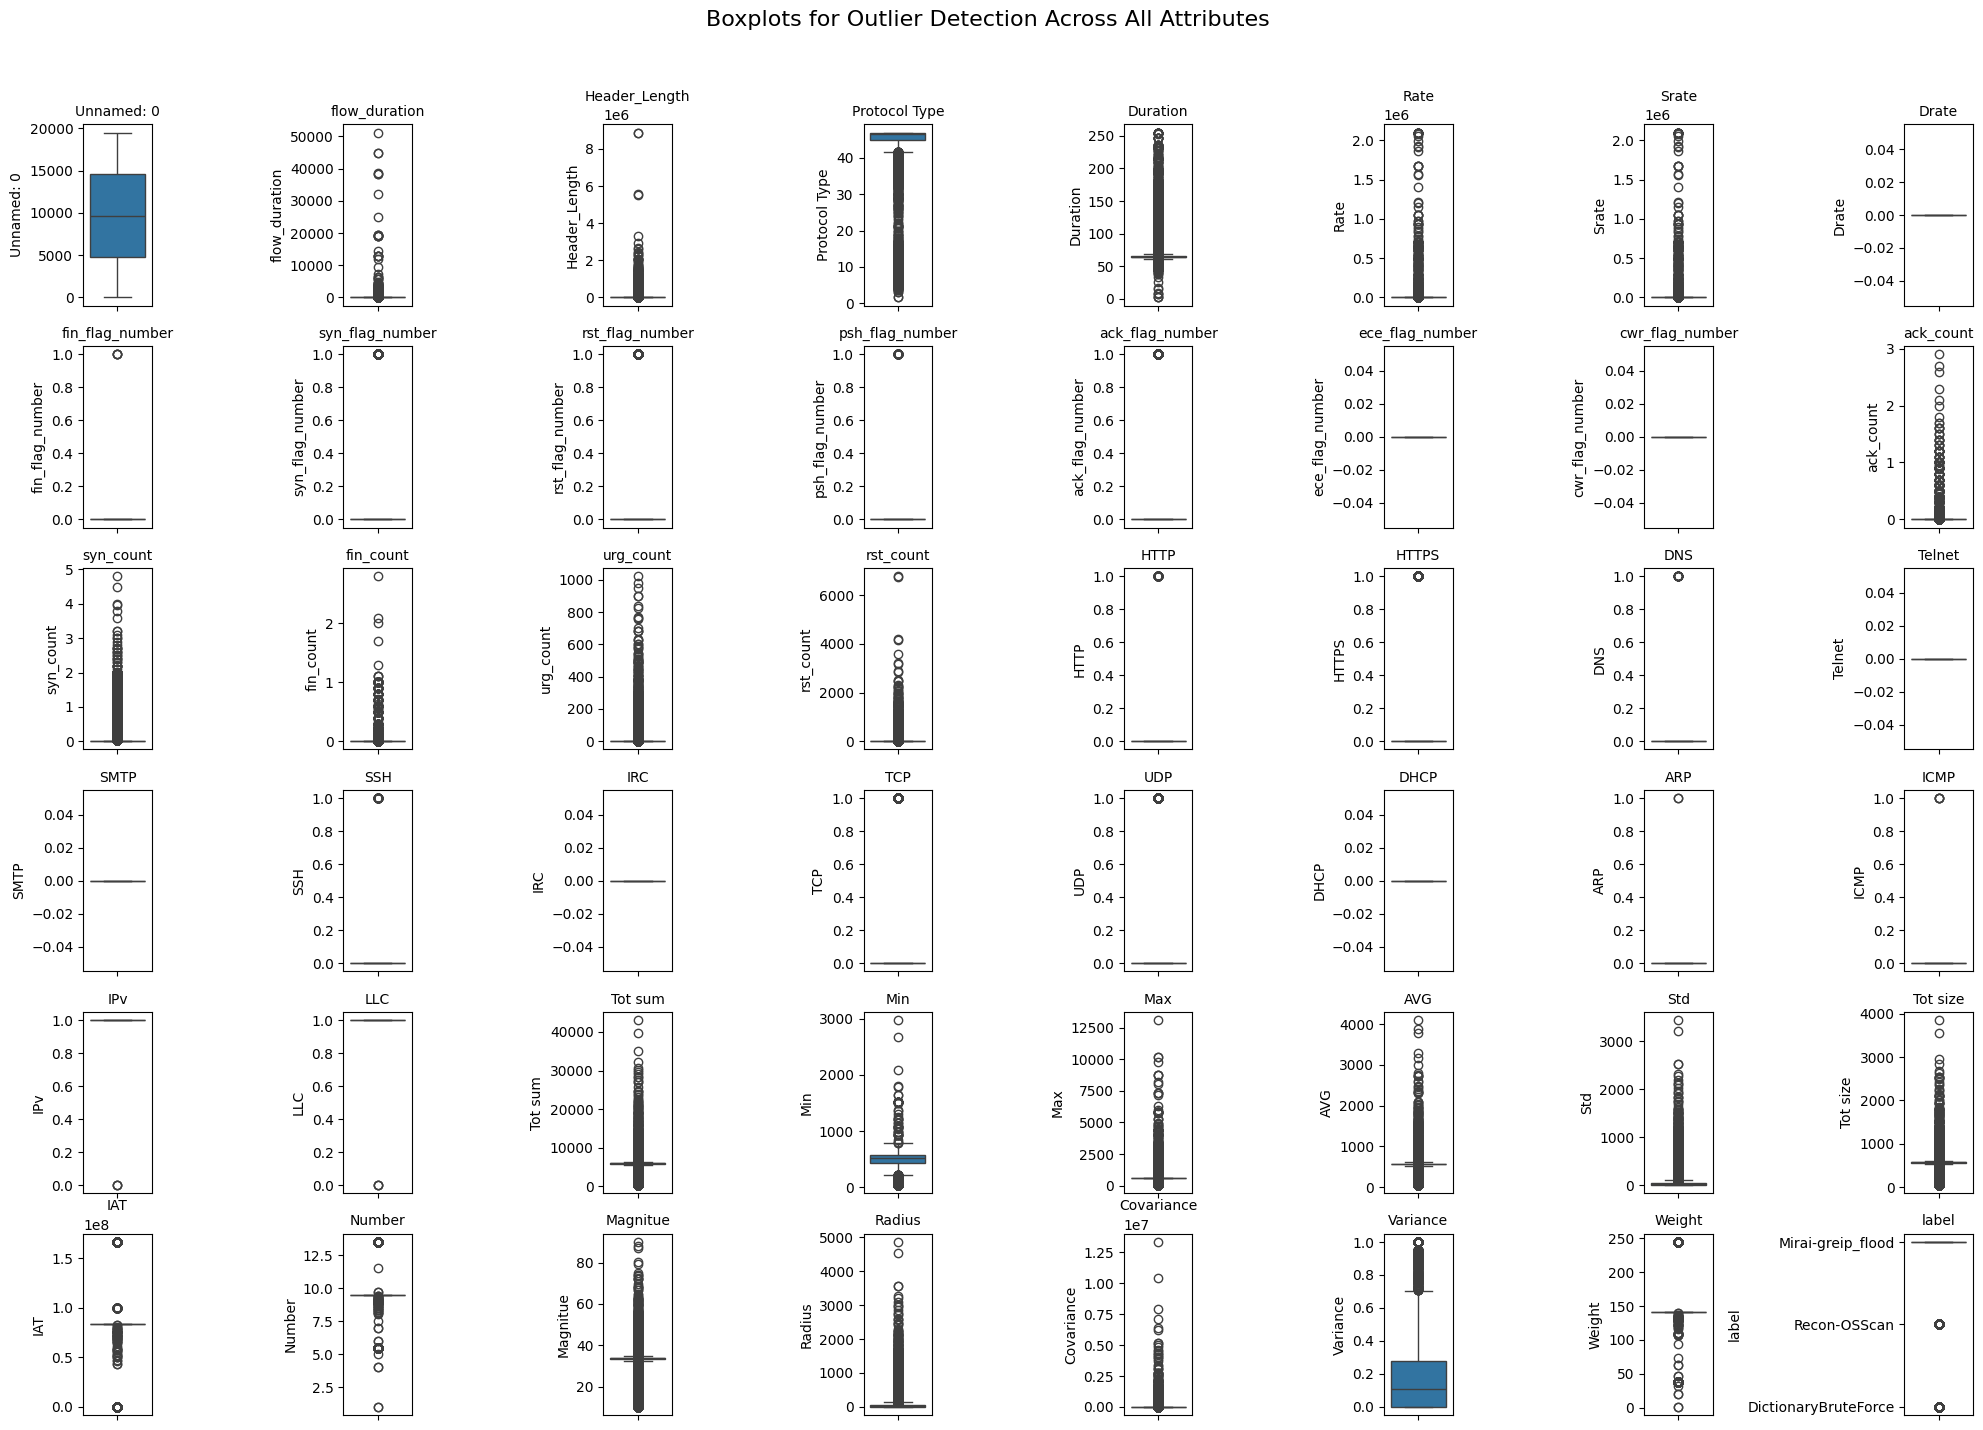

In [ ]:
# Set up a grid for 48 subplots (6 rows x 8 columns)
fig, axes = plt.subplots(6, 8, figsize=(20, 15))
fig.suptitle("Boxplots for Outlier Detection Across All Attributes", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each column and create a boxplot in its subplot
for i, col in enumerate(iotData.columns):
    sns.boxplot(data=iotData[col], ax=axes[i])
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **Data Cleaning, Splitting and Feature Scaling**

In [ ]:
# Columns to be removed
columns_to_remove = [
    'Unnamed: 0', 'Drate', 'ece_flag_number', 'cwr_flag_number', 'SMTP', 'IRC', 'Telnet', 'DHCP'
]

# Remove the selected columns
clean_iotData = iotData.drop(columns=columns_to_remove)

# Display the first few rows of the cleaned dataset to confirm
clean_iotData.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,0.00,46.53,63.36,22.666768,22.666768,0,0,0,0,...,3.472171,572.82,83647298.08,9.5,33.975197,4.949597,408.368004,0.03,141.55,Mirai-greip_flood
1,0.000000,0.00,45.16,71.64,30.076685,30.076685,0,0,0,0,...,40.071279,557.68,83651098.76,9.5,33.204502,56.724539,8981.817205,0.18,141.55,Mirai-greip_flood
2,0.155276,41.75,41.26,70.45,27595.714830,27595.714830,0,0,0,0,...,102.663423,499.11,83581706.66,9.5,31.277104,145.292553,20348.252270,0.61,141.55,Mirai-greip_flood
3,0.000000,0.00,47.00,64.00,5.858490,5.858490,0,0,0,0,...,0.000000,578.00,83581699.68,9.5,34.000000,0.000000,0.000000,0.00,141.55,Mirai-greip_flood
4,0.000000,0.00,47.00,64.00,53.647950,53.647950,0,0,0,0,...,0.000000,578.00,83573865.37,9.5,34.000000,0.000000,0.000000,0.00,141.55,Mirai-greip_flood


In [ ]:
# Step 2: Encode the Target Variable
le = LabelEncoder()
clean_iotData['label'] = le.fit_transform(clean_iotData['label'])

# Display the first few rows of the cleaned and preprocessed dataset
clean_iotData.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,0.00,46.53,63.36,22.666768,22.666768,0,0,0,0,...,3.472171,572.82,83647298.08,9.5,33.975197,4.949597,408.368004,0.03,141.55,1
1,0.000000,0.00,45.16,71.64,30.076685,30.076685,0,0,0,0,...,40.071279,557.68,83651098.76,9.5,33.204502,56.724539,8981.817205,0.18,141.55,1
2,0.155276,41.75,41.26,70.45,27595.714830,27595.714830,0,0,0,0,...,102.663423,499.11,83581706.66,9.5,31.277104,145.292553,20348.252270,0.61,141.55,1
3,0.000000,0.00,47.00,64.00,5.858490,5.858490,0,0,0,0,...,0.000000,578.00,83581699.68,9.5,34.000000,0.000000,0.000000,0.00,141.55,1
4,0.000000,0.00,47.00,64.00,53.647950,53.647950,0,0,0,0,...,0.000000,578.00,83573865.37,9.5,34.000000,0.000000,0.000000,0.00,141.55,1


In [ ]:
# Step 3: Split the Data into Train and Test Sets
X = clean_iotData.drop(columns=['label'])  # Features
y = clean_iotData['label']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Step 3: Feature Scaling (StandardScaler for scaling numeric features)
# For classifiers like SVM, k-NN, and MLP, we apply scaling; for tree-based models, we can skip it.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# X_train_scaled and X_val_scaled can now be fed into classifiers like SVM, k-NN, and MLP

# **Training and testing classifiers 70/30 split**

In [ ]:
# Defining a mapping of class indices to attack names
class_names = {0: "Mirai-greip_flood", 1: "Recon-OSScan", 2: "DictionaryBruteForce"} # for ROC Curve
cm_class_names = ["Mirai-greip_flood", "Recon-OSScan", "DictionaryBruteForce"] # for confusion matrix

**Decision Tree**

Decision Tree Accuracy: 0.9914529914529915
Decision Tree Confusion Matrix:


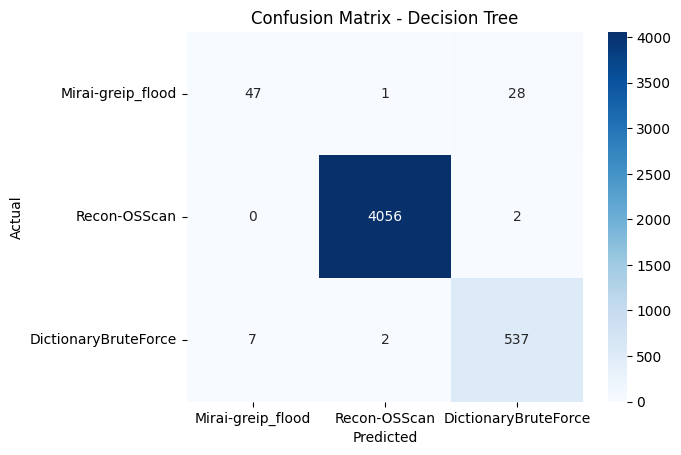


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.62      0.72        76
           1       1.00      1.00      1.00      4058
           2       0.95      0.98      0.96       546

    accuracy                           0.99      4680
   macro avg       0.94      0.87      0.90      4680
weighted avg       0.99      0.99      0.99      4680

DecisionTreeClassifier(max_depth=10, random_state=42) Overall ROC AUC Score (OvR): 0.9773


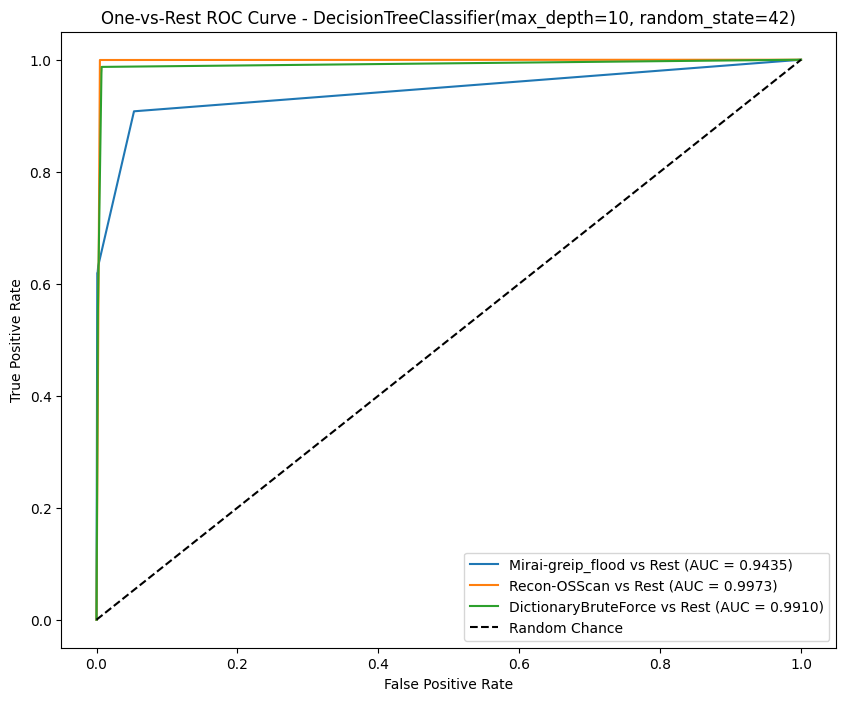

In [ ]:
# Initialize and train models

# 1. Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)  # max_depth limits tree complexity
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt)}')

y_pred_dt = dt_model.predict(X_test)

# Confusion Matrix and Classification Report
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("Decision Tree Confusion Matrix:")
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

# Check if model supports probability prediction
if hasattr(dt_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = dt_model.predict_proba(X_test)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{dt_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {dt_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{dt_model} does not support probability prediction for ROC AUC.")

**k-Nearest Neighbors**

k-NN Accuracy: 0.9818376068376068
k-NN Confusion Matrix:


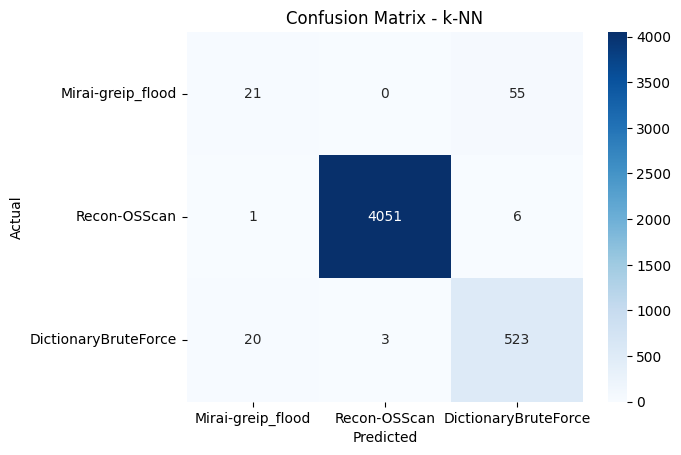


k-NN Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.28      0.36        76
           1       1.00      1.00      1.00      4058
           2       0.90      0.96      0.93       546

    accuracy                           0.98      4680
   macro avg       0.80      0.74      0.76      4680
weighted avg       0.98      0.98      0.98      4680

KNeighborsClassifier() Overall ROC AUC Score (OvR): 0.9446


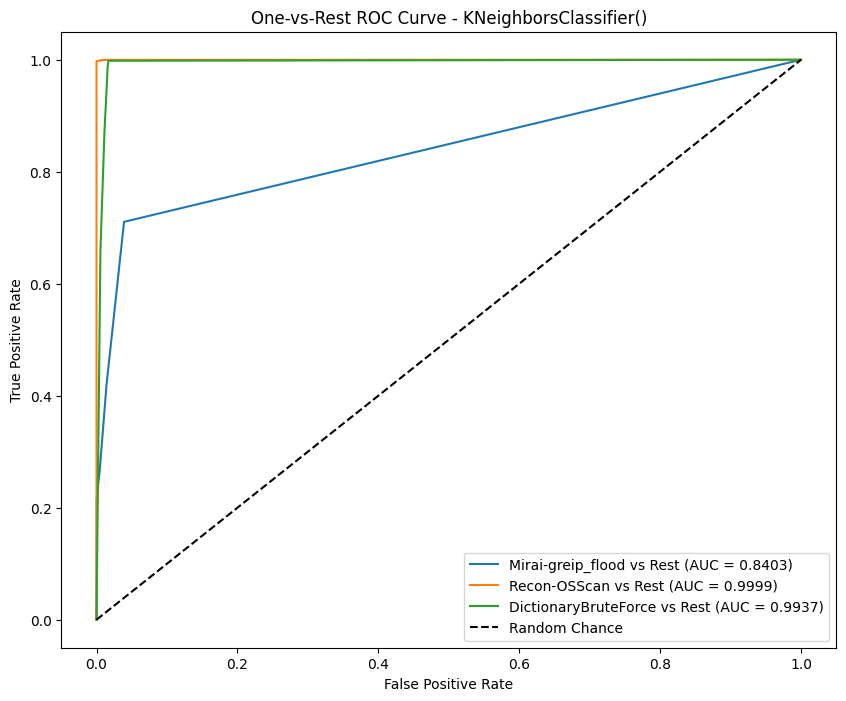

In [ ]:
# 2. k-Nearest Neighbors (k-NN)
knn_model = KNeighborsClassifier(n_neighbors=5)  # n_neighbors=5 is common, balancing accuracy and computation
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)
print(f'k-NN Accuracy: {accuracy_score(y_test, y_pred_knn)}')

y_pred_knn = knn_model.predict(X_test_scaled)

# Confusion Matrix and Classification Report
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("k-NN Confusion Matrix:")
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - k-NN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nk-NN Classification Report:\n", classification_report(y_test, y_pred_knn))

# Check if model supports probability prediction
if hasattr(knn_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = knn_model.predict_proba(X_test_scaled)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{knn_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {knn_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{knn_model} does not support probability prediction for ROC AUC.")

**Support Vector Machine**

SVM Accuracy: 0.9846153846153847
SVM Confusion Matrix:


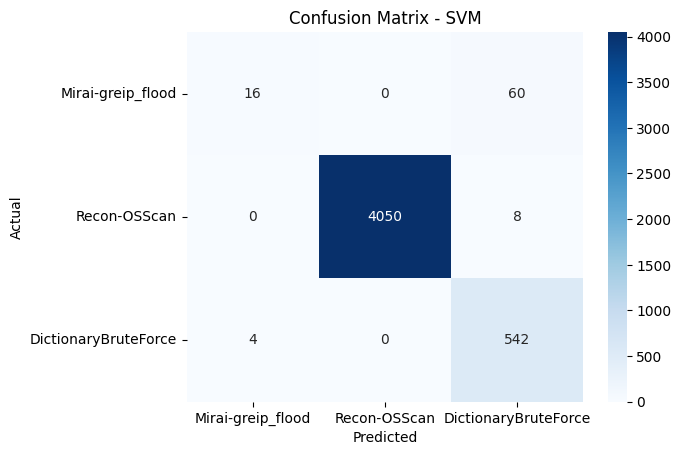


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.21      0.33        76
           1       1.00      1.00      1.00      4058
           2       0.89      0.99      0.94       546

    accuracy                           0.98      4680
   macro avg       0.90      0.73      0.76      4680
weighted avg       0.98      0.98      0.98      4680

SVC(probability=True, random_state=42) Overall ROC AUC Score (OvR): 0.9869


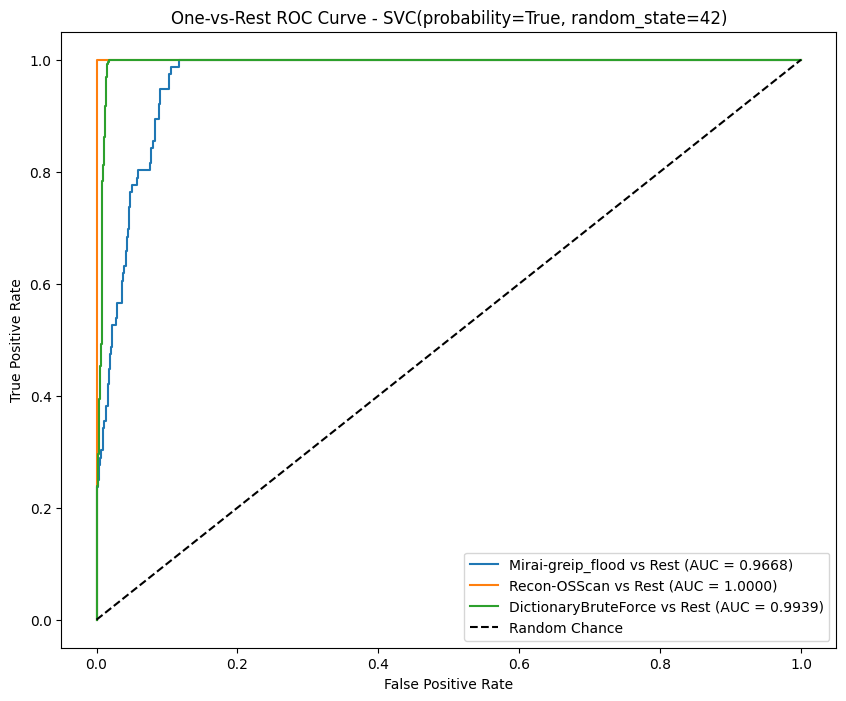

In [ ]:
# 3. Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)  # 'rbf' kernel handles non-linear data, C=1.0 is default
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
print(f'SVM Accuracy: {accuracy_score(y_test, y_pred_svm)}')

y_pred_svm = svm_model.predict(X_test_scaled)

# Confusion Matrix and Classification Report
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("SVM Confusion Matrix:")
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))

# Check if model supports probability prediction
if hasattr(svm_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = svm_model.predict_proba(X_test_scaled)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{svm_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {svm_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{svm_model} does not support probability prediction for ROC AUC.")

**Multilayer Perceptron**

MLP Accuracy: 0.9809829059829059
MLP Confusion Matrix:


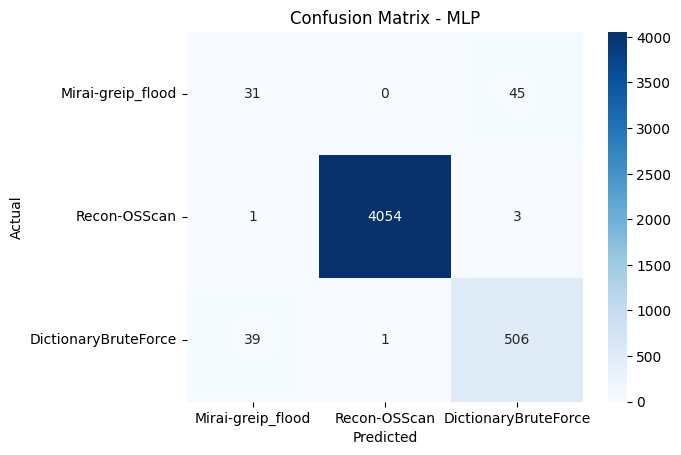


MLP Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.41      0.42        76
           1       1.00      1.00      1.00      4058
           2       0.91      0.93      0.92       546

    accuracy                           0.98      4680
   macro avg       0.78      0.78      0.78      4680
weighted avg       0.98      0.98      0.98      4680

MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=300, random_state=42) Overall ROC AUC Score (OvR): 0.9823


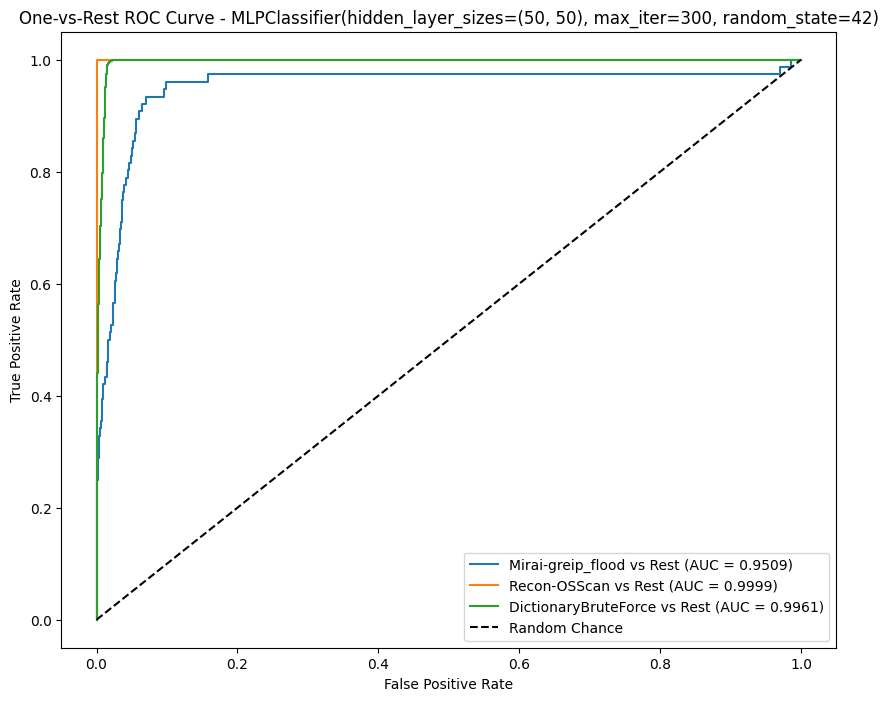

In [ ]:
# 4. Multilayer Perceptron (MLP)
mlp_model = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=300, random_state=42)  # 2 hidden layers with 50 nodes each
mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)
print(f'MLP Accuracy: {accuracy_score(y_test, y_pred_mlp)}')

y_pred_mlp = mlp_model.predict(X_test_scaled)

# Confusion Matrix and Classification Report
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print("MLP Confusion Matrix:")
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nMLP Classification Report:\n", classification_report(y_test, y_pred_mlp))

# Check if model supports probability prediction
if hasattr(mlp_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = mlp_model.predict_proba(X_test_scaled)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{mlp_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {mlp_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{mlp_model} does not support probability prediction for ROC AUC.")

**Random Forest**

Random Forest Accuracy: 0.9925213675213675
Random Forest Confusion Matrix:


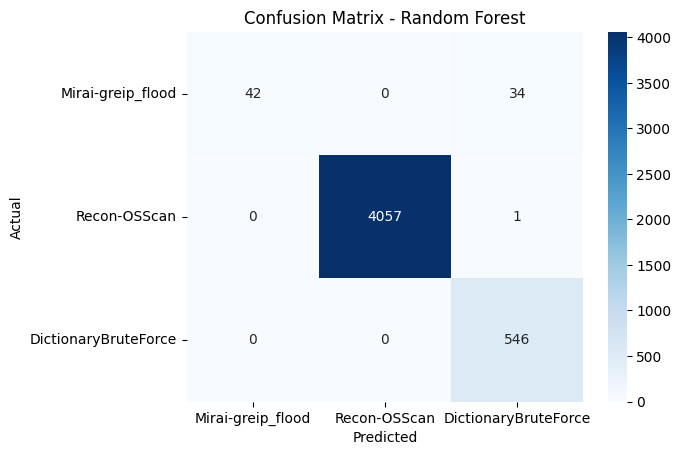


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.55      0.71        76
           1       1.00      1.00      1.00      4058
           2       0.94      1.00      0.97       546

    accuracy                           0.99      4680
   macro avg       0.98      0.85      0.89      4680
weighted avg       0.99      0.99      0.99      4680

RandomForestClassifier(max_depth=10, random_state=42) Overall ROC AUC Score (OvR): 0.9976


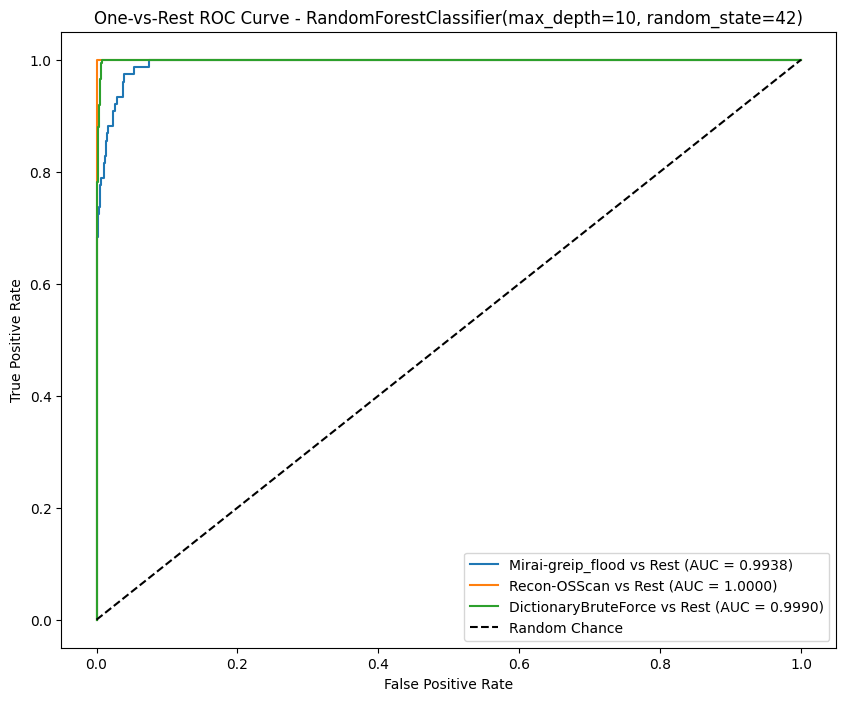

In [ ]:
# 5. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)  # 100 trees, max_depth limits complexity
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(f'Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}')

y_pred_rf = rf_model.predict(X_test)

# Confusion Matrix and Classification Report
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:")
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Check if model supports probability prediction
if hasattr(rf_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = rf_model.predict_proba(X_test)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{rf_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {rf_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{rf_model} does not support probability prediction for ROC AUC.")

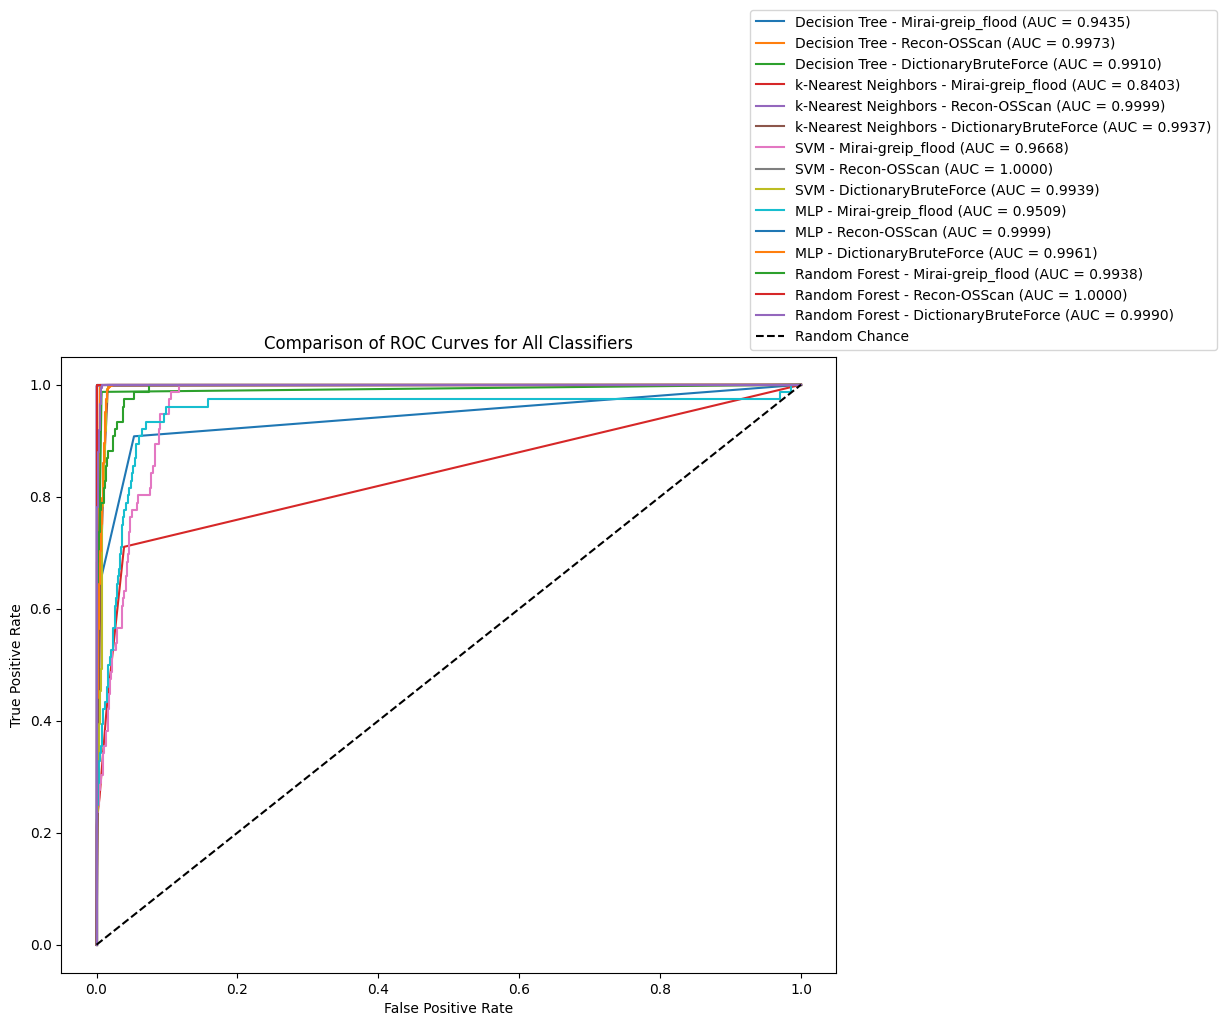

In [ ]:
# Dictionary to hold models and their names
models = {
    "Decision Tree": dt_model,
    "k-Nearest Neighbors": knn_model,
    "SVM": svm_model,
    "MLP": mlp_model,
    "Random Forest": rf_model
}

# Plot ROC curve for each classifier
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    if hasattr(model, "predict_proba"):  # Only plot if model supports probability prediction
        y_prob = model.predict_proba(X_test_scaled if model_name in ["k-Nearest Neighbors", "SVM", "MLP"] else X_test)

        # For multi-class ROC, calculate the One-vs-Rest (OvR) ROC curve for each class and average
        for i in range(y_prob.shape[1]):  # Loop over each class
            y_test_binary = (y_test == i).astype(int)  # Binary labels for current class
            fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

            # Plot the ROC curve for the current class for each classifier
            plt.plot(fpr, tpr, label=f"{model_name} - {class_names[i]} (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Final plot adjustments
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Comparison of ROC Curves for All Classifiers")
plt.legend(loc="lower right", bbox_to_anchor=(1.5, 1))
plt.show()

# **Training and testing classifiers 80/20 split**

In [ ]:
# Step 3: Split the Data into Train and Test Sets
X = clean_iotData.drop(columns=['label'])  # Features
y = clean_iotData['label']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 3: Feature Scaling (StandardScaler for scaling numeric features)
# For classifiers like SVM, k-NN, and MLP, we apply scaling; for tree-based models, we can skip it.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# X_train_scaled and X_val_scaled can now be fed into classifiers like SVM, k-NN, and MLP

Decision Tree Accuracy: 0.9926282051282052
Decision Tree Confusion Matrix:


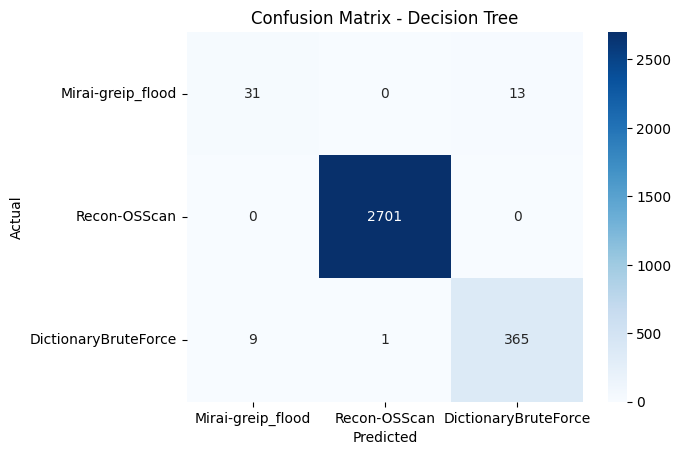


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.70      0.74        44
           1       1.00      1.00      1.00      2701
           2       0.97      0.97      0.97       375

    accuracy                           0.99      3120
   macro avg       0.91      0.89      0.90      3120
weighted avg       0.99      0.99      0.99      3120

DecisionTreeClassifier(max_depth=10, random_state=42) Overall ROC AUC Score (OvR): 0.9866


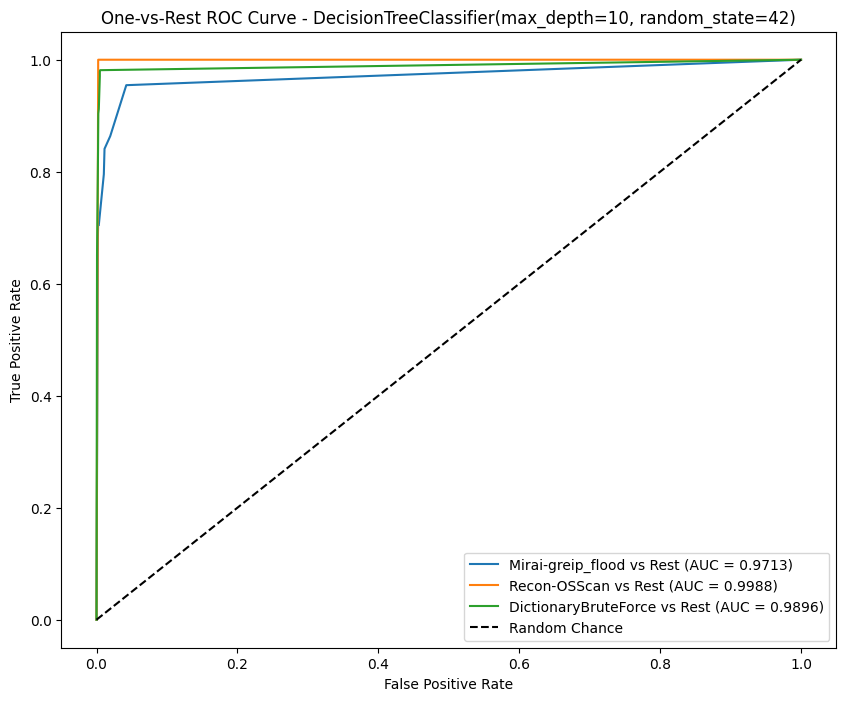

In [ ]:
# Initialize and train models

# 1. Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)  # max_depth limits tree complexity
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt)}')

y_pred_dt = dt_model.predict(X_test)

# Confusion Matrix and Classification Report
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("Decision Tree Confusion Matrix:")
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

# Check if model supports probability prediction
if hasattr(dt_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = dt_model.predict_proba(X_test)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{dt_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {dt_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{dt_model} does not support probability prediction for ROC AUC.")

k-NN Accuracy: 0.9833333333333333
k-NN Confusion Matrix:


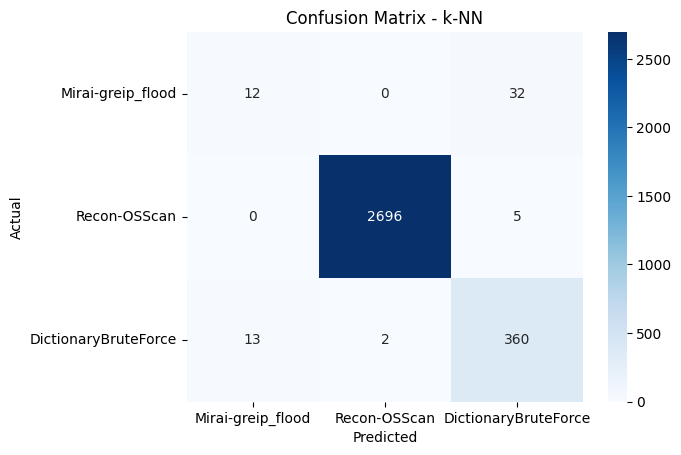


k-NN Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.27      0.35        44
           1       1.00      1.00      1.00      2701
           2       0.91      0.96      0.93       375

    accuracy                           0.98      3120
   macro avg       0.80      0.74      0.76      3120
weighted avg       0.98      0.98      0.98      3120

KNeighborsClassifier() Overall ROC AUC Score (OvR): 0.9557


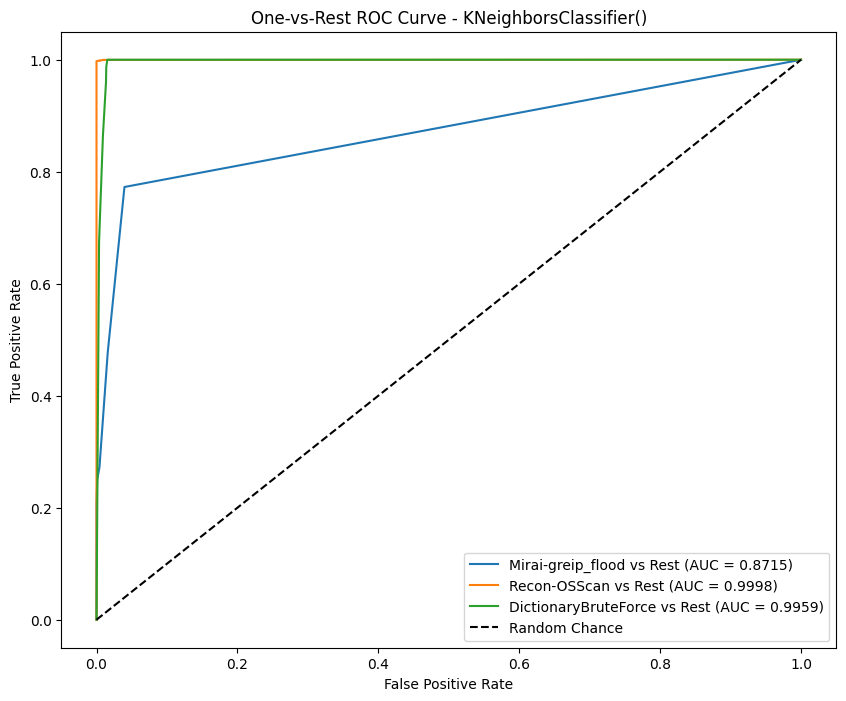

In [ ]:
# 2. k-Nearest Neighbors (k-NN)
knn_model = KNeighborsClassifier(n_neighbors=5)  # n_neighbors=5 is common, balancing accuracy and computation
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)
print(f'k-NN Accuracy: {accuracy_score(y_test, y_pred_knn)}')

y_pred_knn = knn_model.predict(X_test_scaled)

# Confusion Matrix and Classification Report
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("k-NN Confusion Matrix:")
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - k-NN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nk-NN Classification Report:\n", classification_report(y_test, y_pred_knn))

# Check if model supports probability prediction
if hasattr(knn_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = knn_model.predict_proba(X_test_scaled)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{knn_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {knn_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{knn_model} does not support probability prediction for ROC AUC.")

SVM Accuracy: 0.9852564102564103
SVM Confusion Matrix:


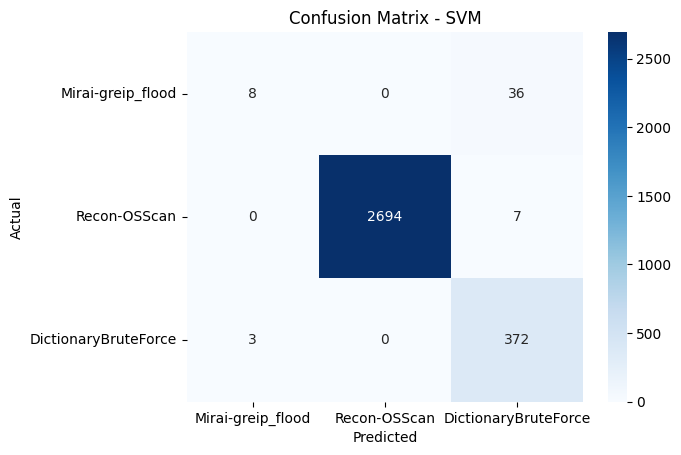


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.18      0.29        44
           1       1.00      1.00      1.00      2701
           2       0.90      0.99      0.94       375

    accuracy                           0.99      3120
   macro avg       0.87      0.72      0.74      3120
weighted avg       0.98      0.99      0.98      3120

SVC(probability=True, random_state=42) Overall ROC AUC Score (OvR): 0.9865


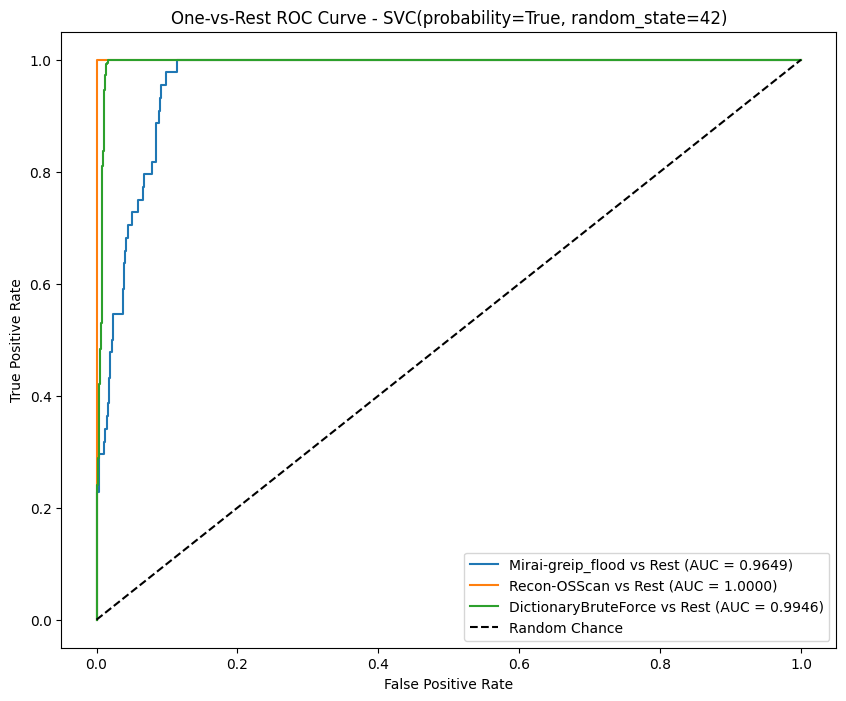

In [ ]:
# 3. Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)  # 'rbf' kernel handles non-linear data, C=1.0 is default
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
print(f'SVM Accuracy: {accuracy_score(y_test, y_pred_svm)}')

y_pred_svm = svm_model.predict(X_test_scaled)

# Confusion Matrix and Classification Report
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("SVM Confusion Matrix:")
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))

# Check if model supports probability prediction
if hasattr(svm_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = svm_model.predict_proba(X_test_scaled)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{svm_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {svm_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{svm_model} does not support probability prediction for ROC AUC.")

MLP Accuracy: 0.9852564102564103
MLP Confusion Matrix:


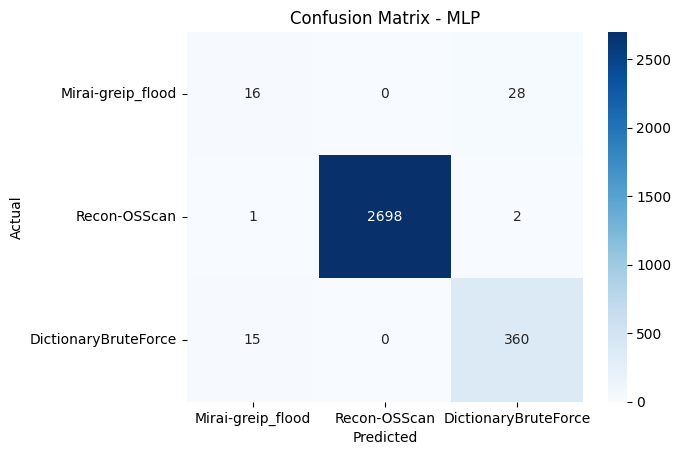


MLP Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.36      0.42        44
           1       1.00      1.00      1.00      2701
           2       0.92      0.96      0.94       375

    accuracy                           0.99      3120
   macro avg       0.81      0.77      0.79      3120
weighted avg       0.98      0.99      0.98      3120

MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=300, random_state=42) Overall ROC AUC Score (OvR): 0.9916


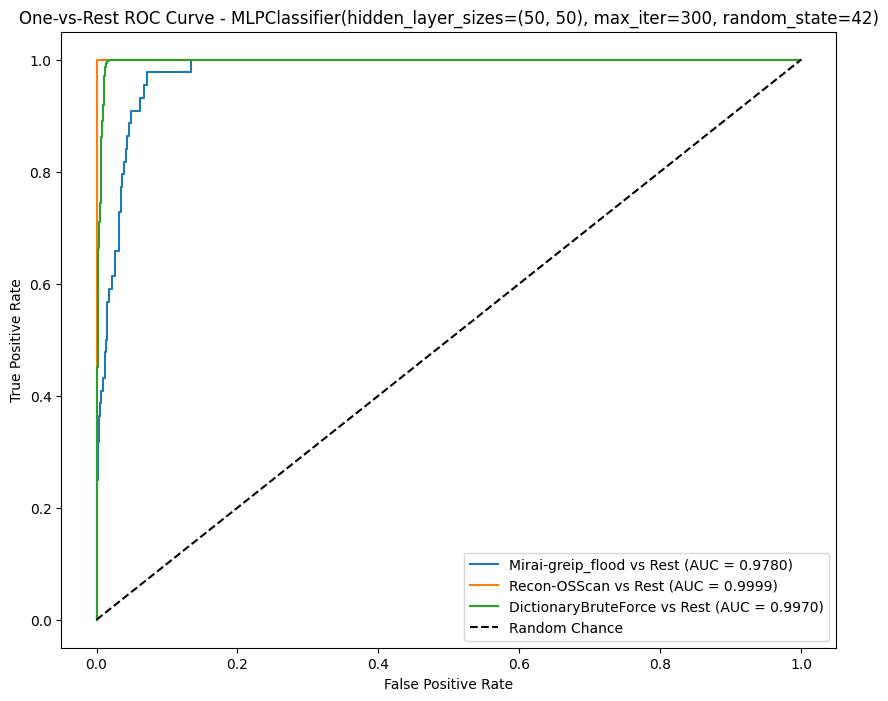

In [ ]:
# 4. Multilayer Perceptron (MLP)
mlp_model = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=300, random_state=42)  # 2 hidden layers with 50 nodes each
mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)
print(f'MLP Accuracy: {accuracy_score(y_test, y_pred_mlp)}')

y_pred_mlp = mlp_model.predict(X_test_scaled)

# Confusion Matrix and Classification Report
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print("MLP Confusion Matrix:")
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nMLP Classification Report:\n", classification_report(y_test, y_pred_mlp))

# Check if model supports probability prediction
if hasattr(mlp_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = mlp_model.predict_proba(X_test_scaled)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{mlp_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {mlp_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{mlp_model} does not support probability prediction for ROC AUC.")

Random Forest Accuracy: 0.9939102564102564
Random Forest Confusion Matrix:


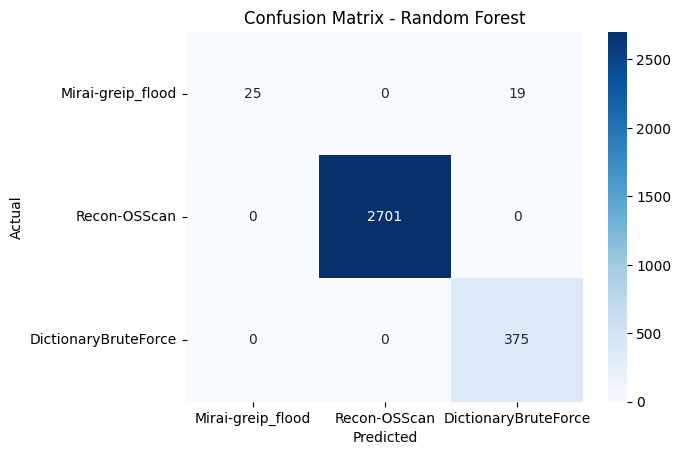


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72        44
           1       1.00      1.00      1.00      2701
           2       0.95      1.00      0.98       375

    accuracy                           0.99      3120
   macro avg       0.98      0.86      0.90      3120
weighted avg       0.99      0.99      0.99      3120

RandomForestClassifier(max_depth=10, random_state=42) Overall ROC AUC Score (OvR): 0.9981


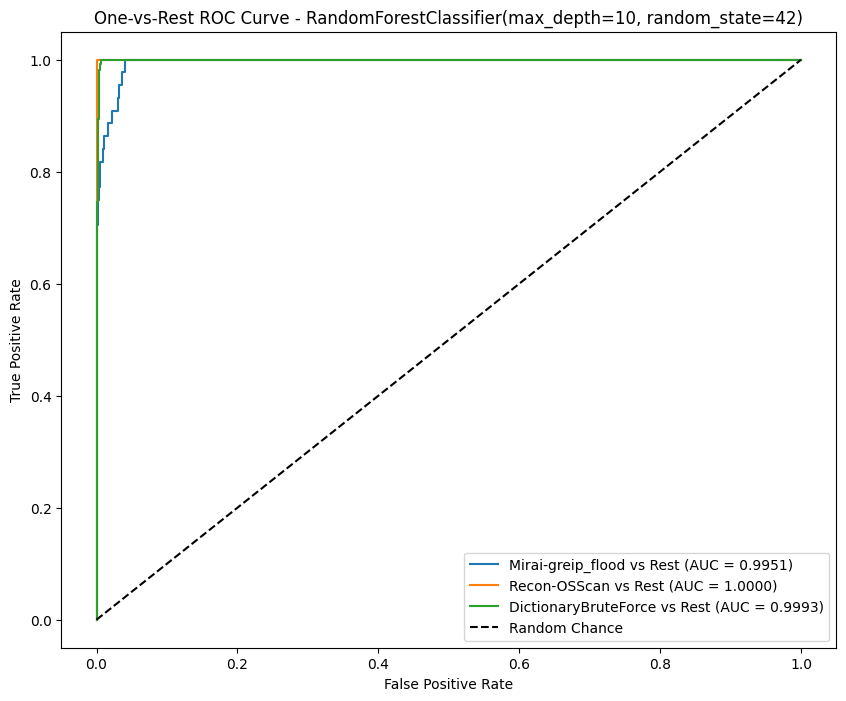

In [ ]:
# 5. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)  # 100 trees, max_depth limits complexity
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(f'Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}')

y_pred_rf = rf_model.predict(X_test)

# Confusion Matrix and Classification Report
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:")
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Check if model supports probability prediction
if hasattr(rf_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = rf_model.predict_proba(X_test)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{rf_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {rf_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{rf_model} does not support probability prediction for ROC AUC.")

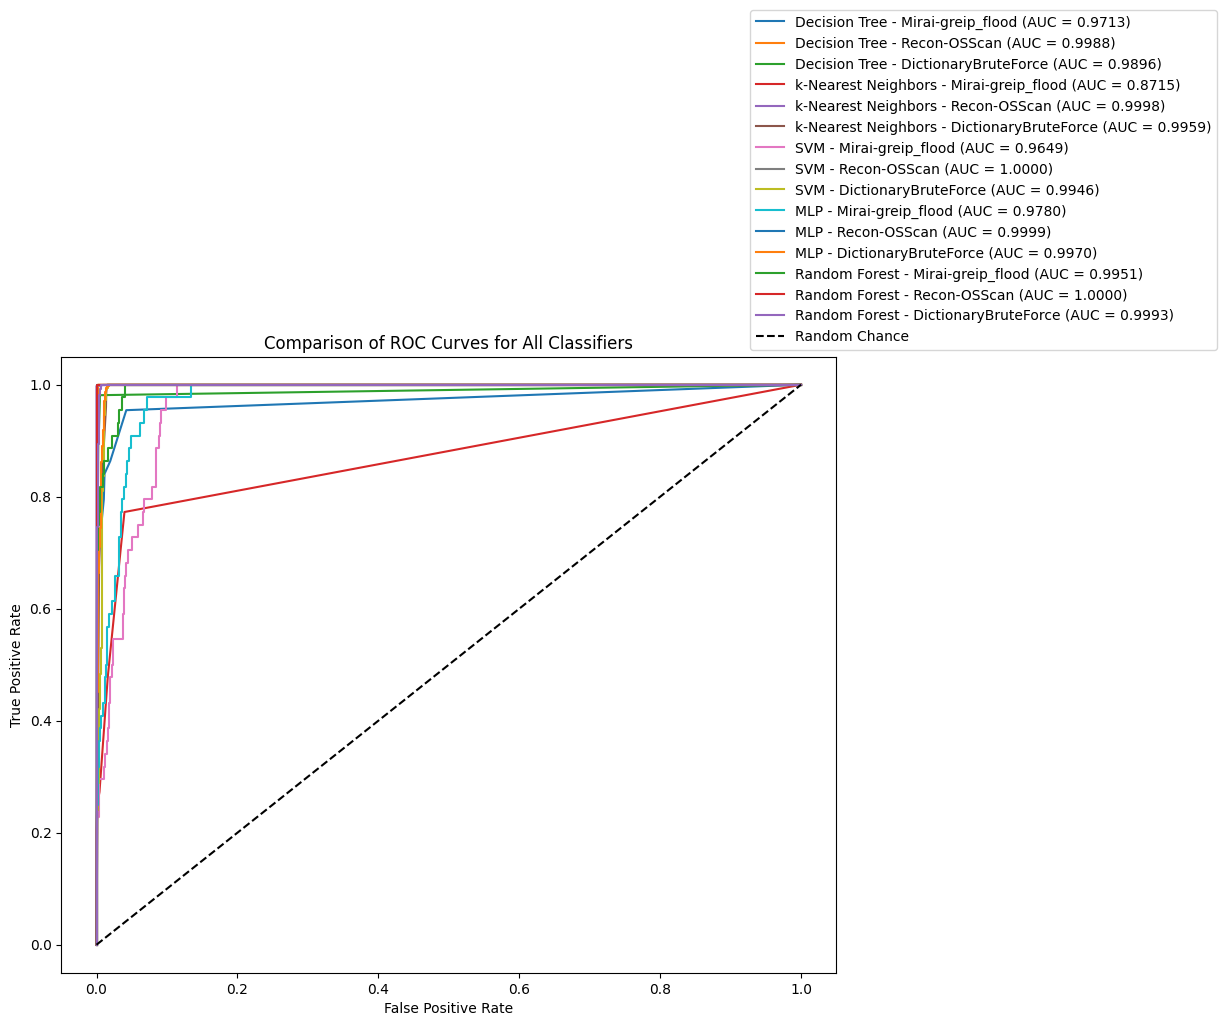

In [ ]:
# Dictionary to hold models and their names
models = {
    "Decision Tree": dt_model,
    "k-Nearest Neighbors": knn_model,
    "SVM": svm_model,
    "MLP": mlp_model,
    "Random Forest": rf_model
}

# Plot ROC curve for each classifier
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    if hasattr(model, "predict_proba"):  # Only plot if model supports probability prediction
        y_prob = model.predict_proba(X_test_scaled if model_name in ["k-Nearest Neighbors", "SVM", "MLP"] else X_test)

        # For multi-class ROC, calculate the One-vs-Rest (OvR) ROC curve for each class and average
        for i in range(y_prob.shape[1]):  # Loop over each class
            y_test_binary = (y_test == i).astype(int)  # Binary labels for current class
            fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

            # Plot the ROC curve for the current class for each classifier
            plt.plot(fpr, tpr, label=f"{model_name} - {class_names[i]} (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Final plot adjustments
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Comparison of ROC Curves for All Classifiers")
plt.legend(loc="lower right", bbox_to_anchor=(1.5, 1))
plt.show()

# **Reduced Data Cleaning and 80/20 split**

In [ ]:
# Columns to be removed
columns_to_remove = [
    'Unnamed: 0'
]

# Remove the selected columns
clean_iotData = iotData.drop(columns=columns_to_remove)

# Display the first few rows of the cleaned dataset to confirm
clean_iotData.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,0.00,46.53,63.36,22.666768,22.666768,0.0,0,0,0,...,3.472171,572.82,83647298.08,9.5,33.975197,4.949597,408.368004,0.03,141.55,Mirai-greip_flood
1,0.000000,0.00,45.16,71.64,30.076685,30.076685,0.0,0,0,0,...,40.071279,557.68,83651098.76,9.5,33.204502,56.724539,8981.817205,0.18,141.55,Mirai-greip_flood
2,0.155276,41.75,41.26,70.45,27595.714830,27595.714830,0.0,0,0,0,...,102.663423,499.11,83581706.66,9.5,31.277104,145.292553,20348.252270,0.61,141.55,Mirai-greip_flood
3,0.000000,0.00,47.00,64.00,5.858490,5.858490,0.0,0,0,0,...,0.000000,578.00,83581699.68,9.5,34.000000,0.000000,0.000000,0.00,141.55,Mirai-greip_flood
4,0.000000,0.00,47.00,64.00,53.647950,53.647950,0.0,0,0,0,...,0.000000,578.00,83573865.37,9.5,34.000000,0.000000,0.000000,0.00,141.55,Mirai-greip_flood


In [ ]:
# Step 2: Encode the Target Variable
le = LabelEncoder()
clean_iotData['label'] = le.fit_transform(clean_iotData['label'])

# Display the first few rows of the cleaned and preprocessed dataset
clean_iotData.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,0.00,46.53,63.36,22.666768,22.666768,0.0,0,0,0,...,3.472171,572.82,83647298.08,9.5,33.975197,4.949597,408.368004,0.03,141.55,1
1,0.000000,0.00,45.16,71.64,30.076685,30.076685,0.0,0,0,0,...,40.071279,557.68,83651098.76,9.5,33.204502,56.724539,8981.817205,0.18,141.55,1
2,0.155276,41.75,41.26,70.45,27595.714830,27595.714830,0.0,0,0,0,...,102.663423,499.11,83581706.66,9.5,31.277104,145.292553,20348.252270,0.61,141.55,1
3,0.000000,0.00,47.00,64.00,5.858490,5.858490,0.0,0,0,0,...,0.000000,578.00,83581699.68,9.5,34.000000,0.000000,0.000000,0.00,141.55,1
4,0.000000,0.00,47.00,64.00,53.647950,53.647950,0.0,0,0,0,...,0.000000,578.00,83573865.37,9.5,34.000000,0.000000,0.000000,0.00,141.55,1


In [ ]:
# Step 3: Split the Data into Train and Test Sets
X = clean_iotData.drop(columns=['label'])  # Features
y = clean_iotData['label']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 3: Feature Scaling (StandardScaler for scaling numeric features)
# For classifiers like SVM, k-NN, and MLP, we apply scaling; for tree-based models, we can skip it.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# X_train_scaled and X_val_scaled can now be fed into classifiers like SVM, k-NN, and MLP

In [ ]:
# Defining a mapping of class indices to attack names
class_names = {0: "Mirai-greip_flood", 1: "Recon-OSScan", 2: "DictionaryBruteForce"} # for ROC Curve
cm_class_names = ["Mirai-greip_flood", "Recon-OSScan", "DictionaryBruteForce"] # for confusion matrix

Decision Tree Accuracy: 0.992948717948718
Decision Tree Confusion Matrix:


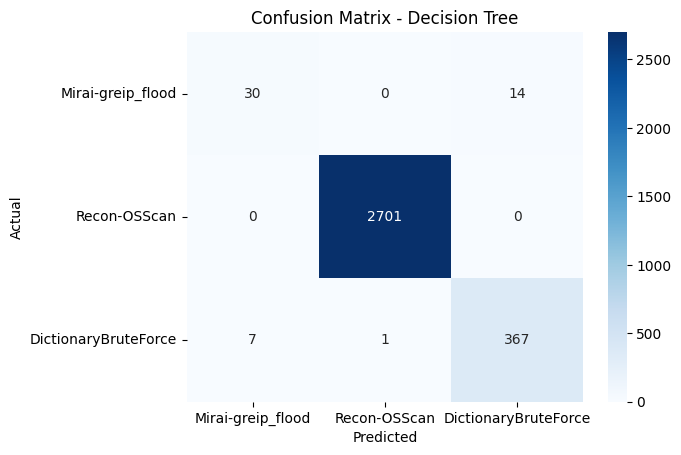


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.68      0.74        44
           1       1.00      1.00      1.00      2701
           2       0.96      0.98      0.97       375

    accuracy                           0.99      3120
   macro avg       0.92      0.89      0.90      3120
weighted avg       0.99      0.99      0.99      3120

DecisionTreeClassifier(max_depth=10, random_state=42) Overall ROC AUC Score (OvR): 0.9836


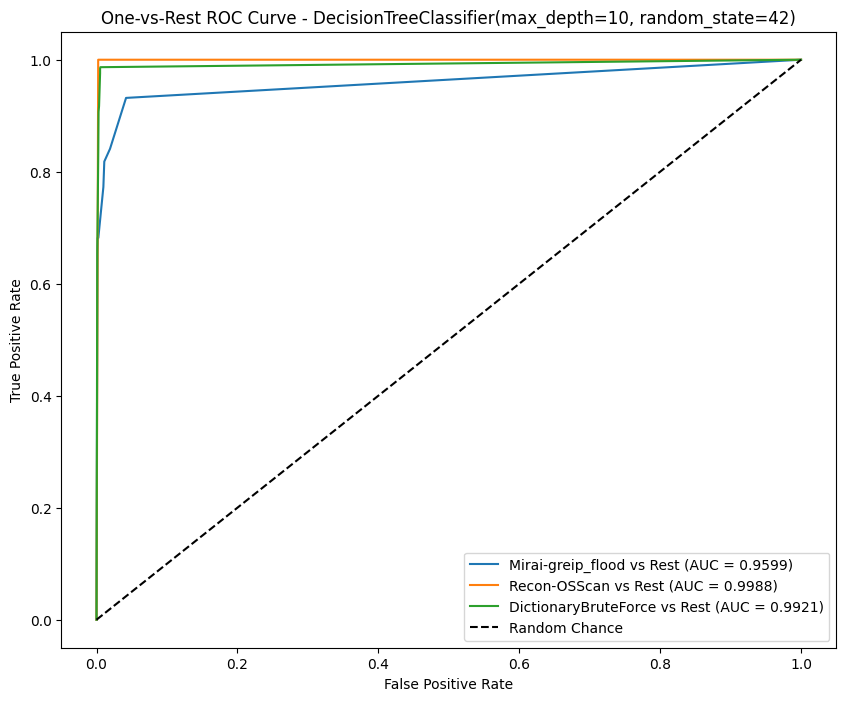

In [ ]:
# Initialize and train models

# 1. Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)  # max_depth limits tree complexity
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt)}')

y_pred_dt = dt_model.predict(X_test)

# Confusion Matrix and Classification Report
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("Decision Tree Confusion Matrix:")
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

# Check if model supports probability prediction
if hasattr(dt_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = dt_model.predict_proba(X_test)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{dt_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {dt_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{dt_model} does not support probability prediction for ROC AUC.")

k-NN Accuracy: 0.9833333333333333
k-NN Confusion Matrix:


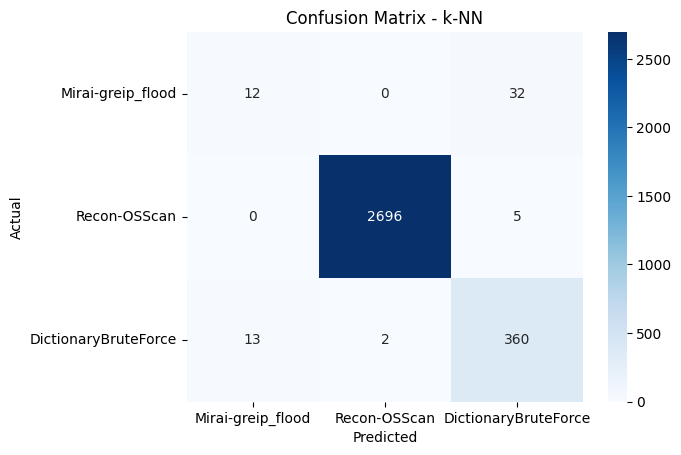


k-NN Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.27      0.35        44
           1       1.00      1.00      1.00      2701
           2       0.91      0.96      0.93       375

    accuracy                           0.98      3120
   macro avg       0.80      0.74      0.76      3120
weighted avg       0.98      0.98      0.98      3120

KNeighborsClassifier() Overall ROC AUC Score (OvR): 0.9557


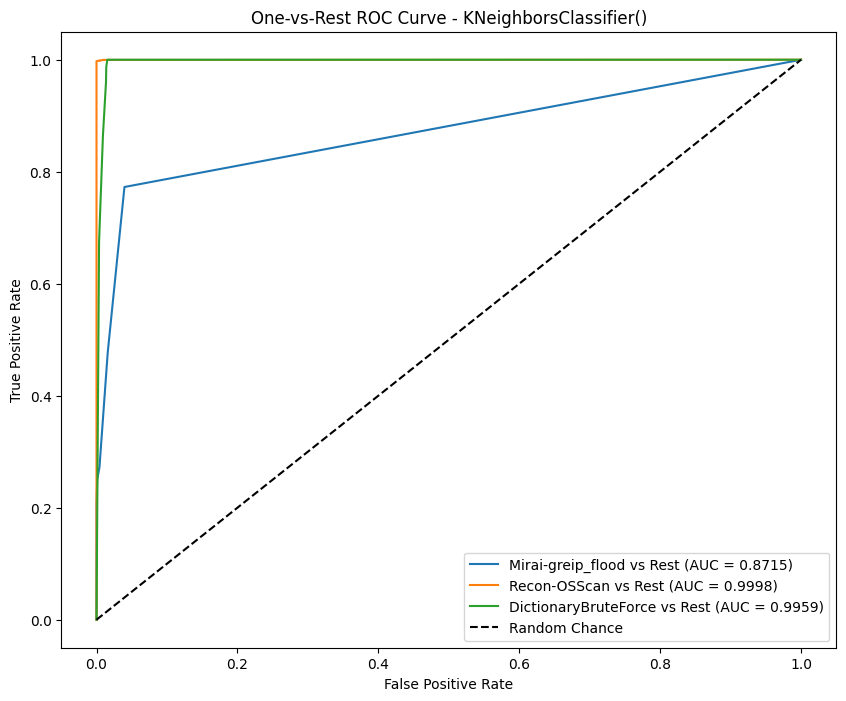

In [ ]:
# 2. k-Nearest Neighbors (k-NN)
knn_model = KNeighborsClassifier(n_neighbors=5)  # n_neighbors=5 is common, balancing accuracy and computation
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)
print(f'k-NN Accuracy: {accuracy_score(y_test, y_pred_knn)}')

y_pred_knn = knn_model.predict(X_test_scaled)

# Confusion Matrix and Classification Report
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("k-NN Confusion Matrix:")
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - k-NN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nk-NN Classification Report:\n", classification_report(y_test, y_pred_knn))

# Check if model supports probability prediction
if hasattr(knn_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = knn_model.predict_proba(X_test_scaled)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{knn_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {knn_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{knn_model} does not support probability prediction for ROC AUC.")

SVM Accuracy: 0.9852564102564103
SVM Confusion Matrix:


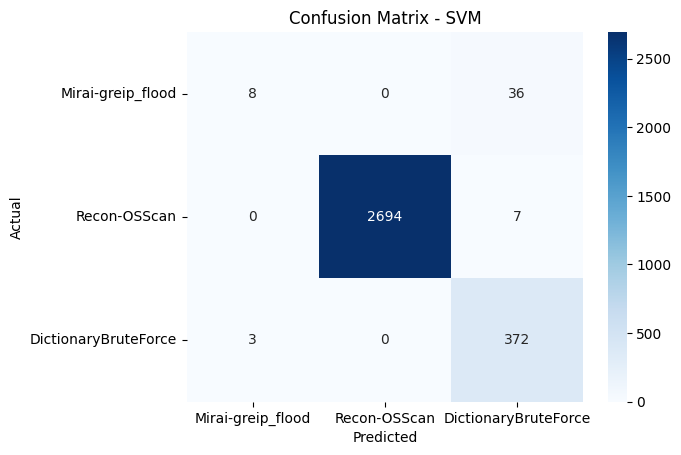


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.18      0.29        44
           1       1.00      1.00      1.00      2701
           2       0.90      0.99      0.94       375

    accuracy                           0.99      3120
   macro avg       0.87      0.72      0.74      3120
weighted avg       0.98      0.99      0.98      3120

SVC(probability=True, random_state=42) Overall ROC AUC Score (OvR): 0.9865


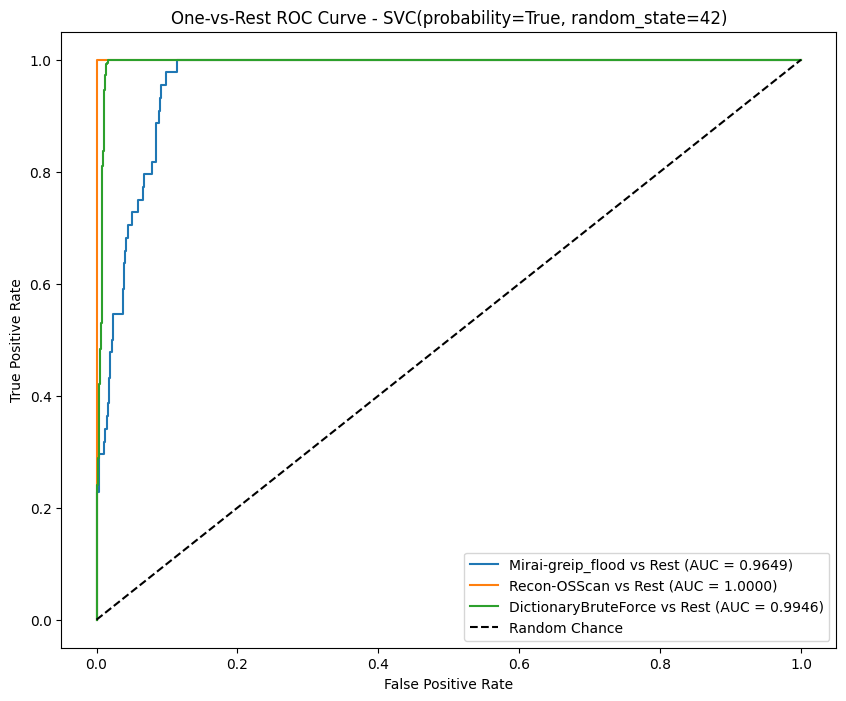

In [ ]:
# 3. Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)  # 'rbf' kernel handles non-linear data, C=1.0 is default
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
print(f'SVM Accuracy: {accuracy_score(y_test, y_pred_svm)}')

y_pred_svm = svm_model.predict(X_test_scaled)

# Confusion Matrix and Classification Report
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("SVM Confusion Matrix:")
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))

# Check if model supports probability prediction
if hasattr(svm_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = svm_model.predict_proba(X_test_scaled)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{svm_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {svm_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{svm_model} does not support probability prediction for ROC AUC.")

MLP Accuracy: 0.9794871794871794
MLP Confusion Matrix:


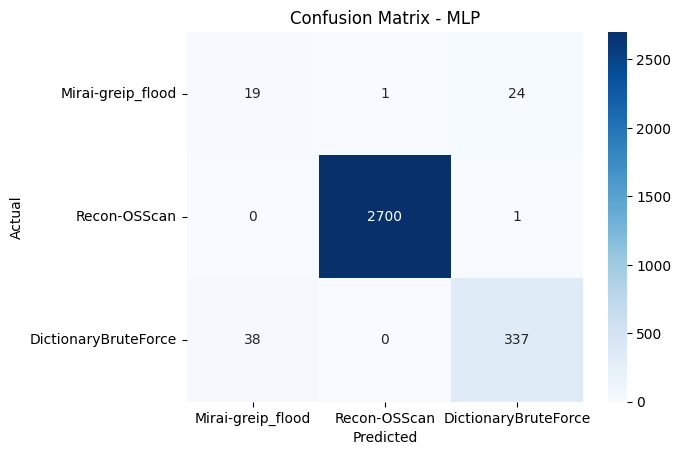


MLP Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.43      0.38        44
           1       1.00      1.00      1.00      2701
           2       0.93      0.90      0.91       375

    accuracy                           0.98      3120
   macro avg       0.75      0.78      0.76      3120
weighted avg       0.98      0.98      0.98      3120

MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=300, random_state=42) Overall ROC AUC Score (OvR): 0.9844


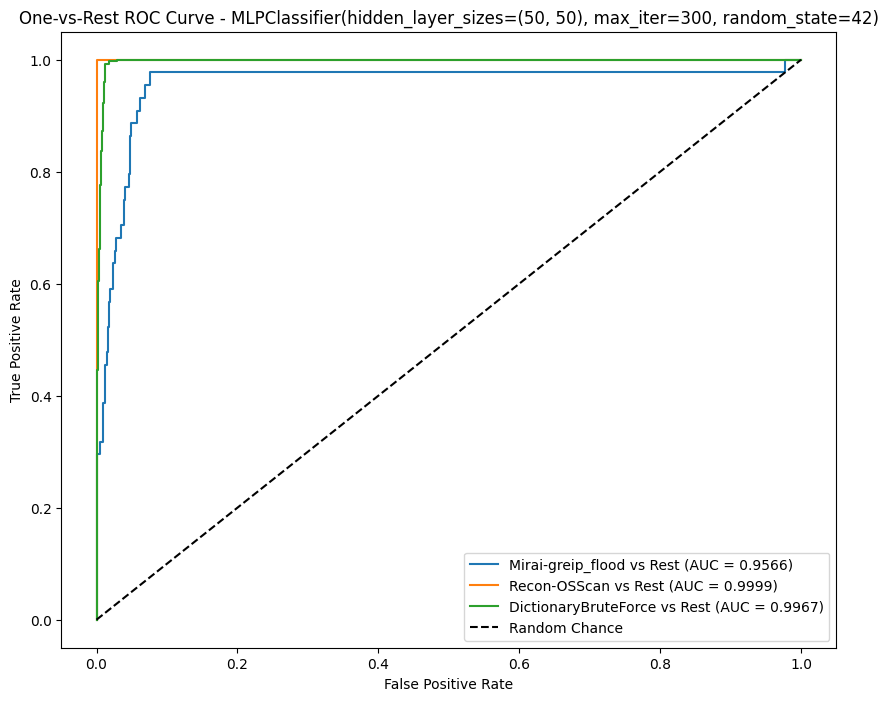

In [ ]:
# 4. Multilayer Perceptron (MLP)
mlp_model = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=300, random_state=42)  # 2 hidden layers with 50 nodes each
mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)
print(f'MLP Accuracy: {accuracy_score(y_test, y_pred_mlp)}')

y_pred_mlp = mlp_model.predict(X_test_scaled)

# Confusion Matrix and Classification Report
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print("MLP Confusion Matrix:")
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nMLP Classification Report:\n", classification_report(y_test, y_pred_mlp))

# Check if model supports probability prediction
if hasattr(mlp_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = mlp_model.predict_proba(X_test_scaled)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{mlp_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {mlp_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{mlp_model} does not support probability prediction for ROC AUC.")

Random Forest Accuracy: 0.9935897435897436
Random Forest Confusion Matrix:


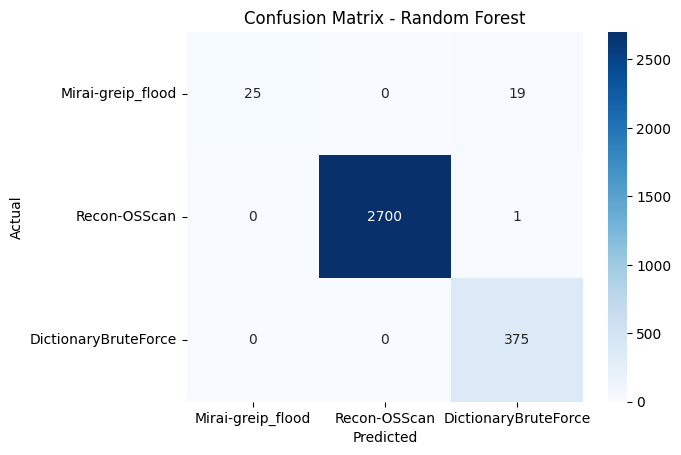


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72        44
           1       1.00      1.00      1.00      2701
           2       0.95      1.00      0.97       375

    accuracy                           0.99      3120
   macro avg       0.98      0.86      0.90      3120
weighted avg       0.99      0.99      0.99      3120

RandomForestClassifier(max_depth=10, random_state=42) Overall ROC AUC Score (OvR): 0.9979


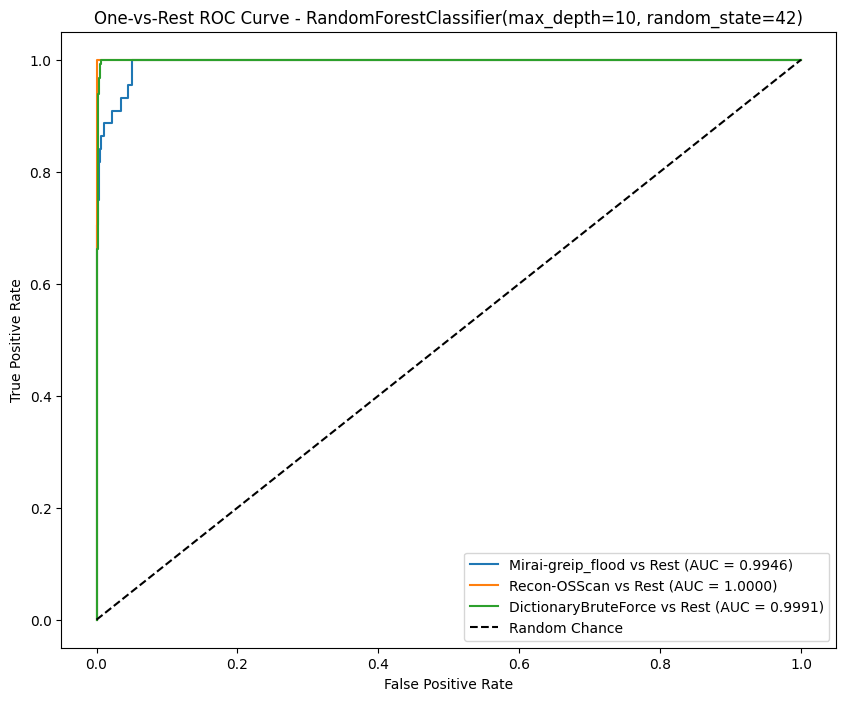

In [ ]:
# 5. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)  # 100 trees, max_depth limits complexity
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(f'Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}')

y_pred_rf = rf_model.predict(X_test)

# Confusion Matrix and Classification Report
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:")
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=cm_class_names, yticklabels=cm_class_names)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Check if model supports probability prediction
if hasattr(rf_model, "predict_proba"):
    # Get full probability predictions for the test set
    y_prob = rf_model.predict_proba(X_test)

    # Calculate the overall ROC AUC score for multi-class (one-vs-rest)
    auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr")
    print(f"{rf_model} Overall ROC AUC Score (OvR): {auc_score:.4f}")

    # Plot ROC Curve for each class (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i in range(y_prob.shape[1]):  # Loop over each class
        # Create binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Compute ROC curve for the current class
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, label=f"{class_names[i]} vs Rest (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"One-vs-Rest ROC Curve - {rf_model}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{rf_model} does not support probability prediction for ROC AUC.")

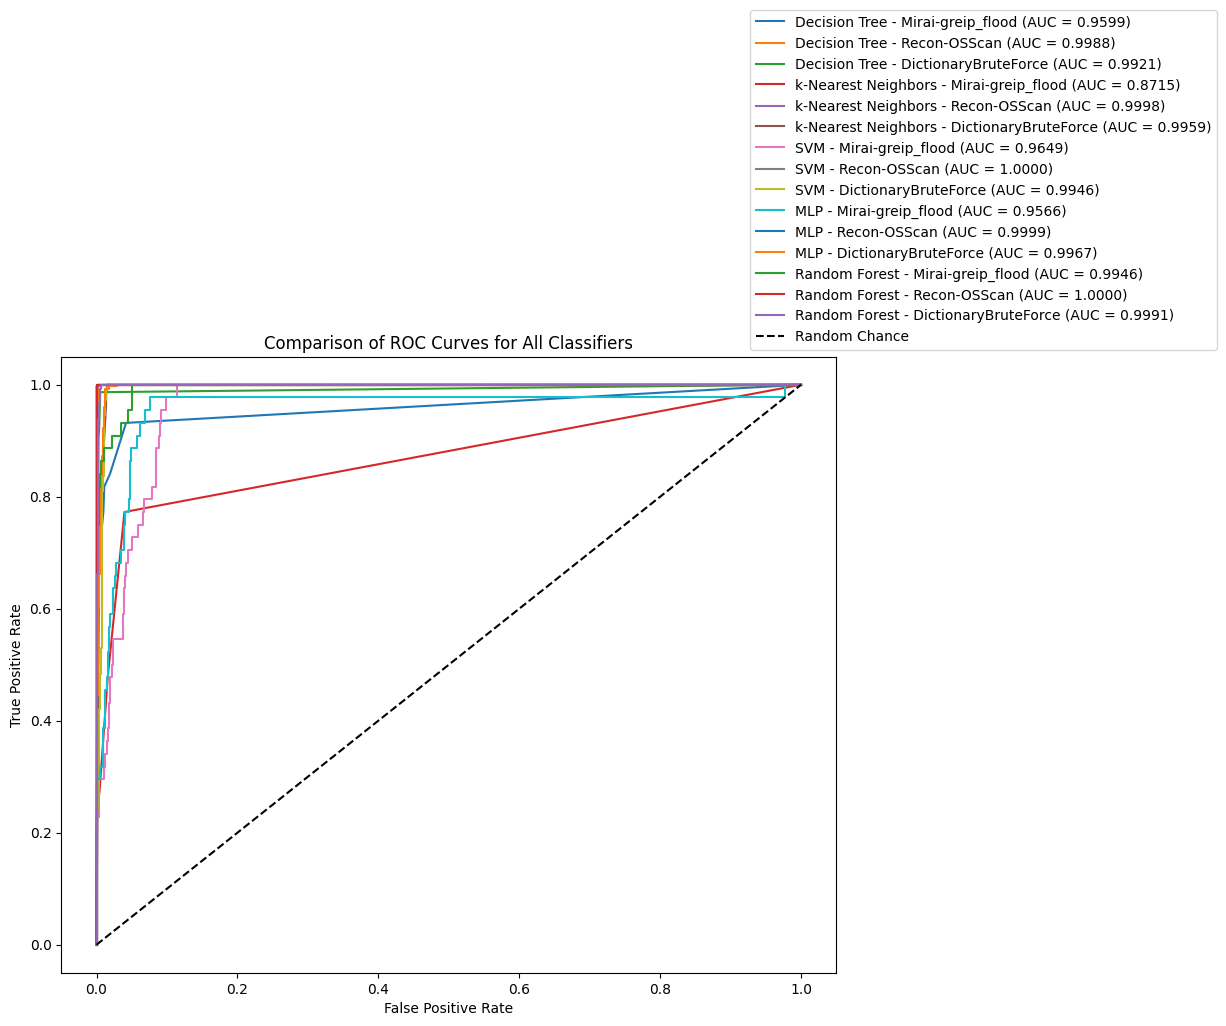

In [ ]:
# Dictionary to hold models and their names
models = {
    "Decision Tree": dt_model,
    "k-Nearest Neighbors": knn_model,
    "SVM": svm_model,
    "MLP": mlp_model,
    "Random Forest": rf_model
}

# Plot ROC curve for each classifier
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    if hasattr(model, "predict_proba"):  # Only plot if model supports probability prediction
        y_prob = model.predict_proba(X_test_scaled if model_name in ["k-Nearest Neighbors", "SVM", "MLP"] else X_test)

        # For multi-class ROC, calculate the One-vs-Rest (OvR) ROC curve for each class and average
        for i in range(y_prob.shape[1]):  # Loop over each class
            y_test_binary = (y_test == i).astype(int)  # Binary labels for current class
            fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])

            # Plot the ROC curve for the current class for each classifier
            plt.plot(fpr, tpr, label=f"{model_name} - {class_names[i]} (AUC = {roc_auc_score(y_test_binary, y_prob[:, i]):.4f})")

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Final plot adjustments
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Comparison of ROC Curves for All Classifiers")
plt.legend(loc="lower right", bbox_to_anchor=(1.5, 1))
plt.show()

# **Prediction of Unknown Dataset using RandomForest**

In [ ]:
# Get the list of columns used during training
training_columns = X.columns  # X is the training feature set before split

# Load the unknown dataset and ensure it has only the training columns
unknown_data = pd.read_csv('unknowndataset.csv')
unknown_data = unknown_data[training_columns]  # Select only the columns that were used for training

# Make predictions using the trained Random Forest model
predictions = rf_model.predict(unknown_data)

# Prepare the submission file
submission_sample = pd.read_csv('test_kaggle_IoT_Instrusion_Detection_submission_sample (1).csv')

# Populate the submission file with predictions
submission_sample['label'] = predictions

# Save the file for submission
submission_sample.to_csv('kaggle_submission.csv', index=False)
print("Submission file 'kaggle_submission.csv' created successfully.")

Submission file 'kaggle_submission.csv' created successfully.


# **Trying**

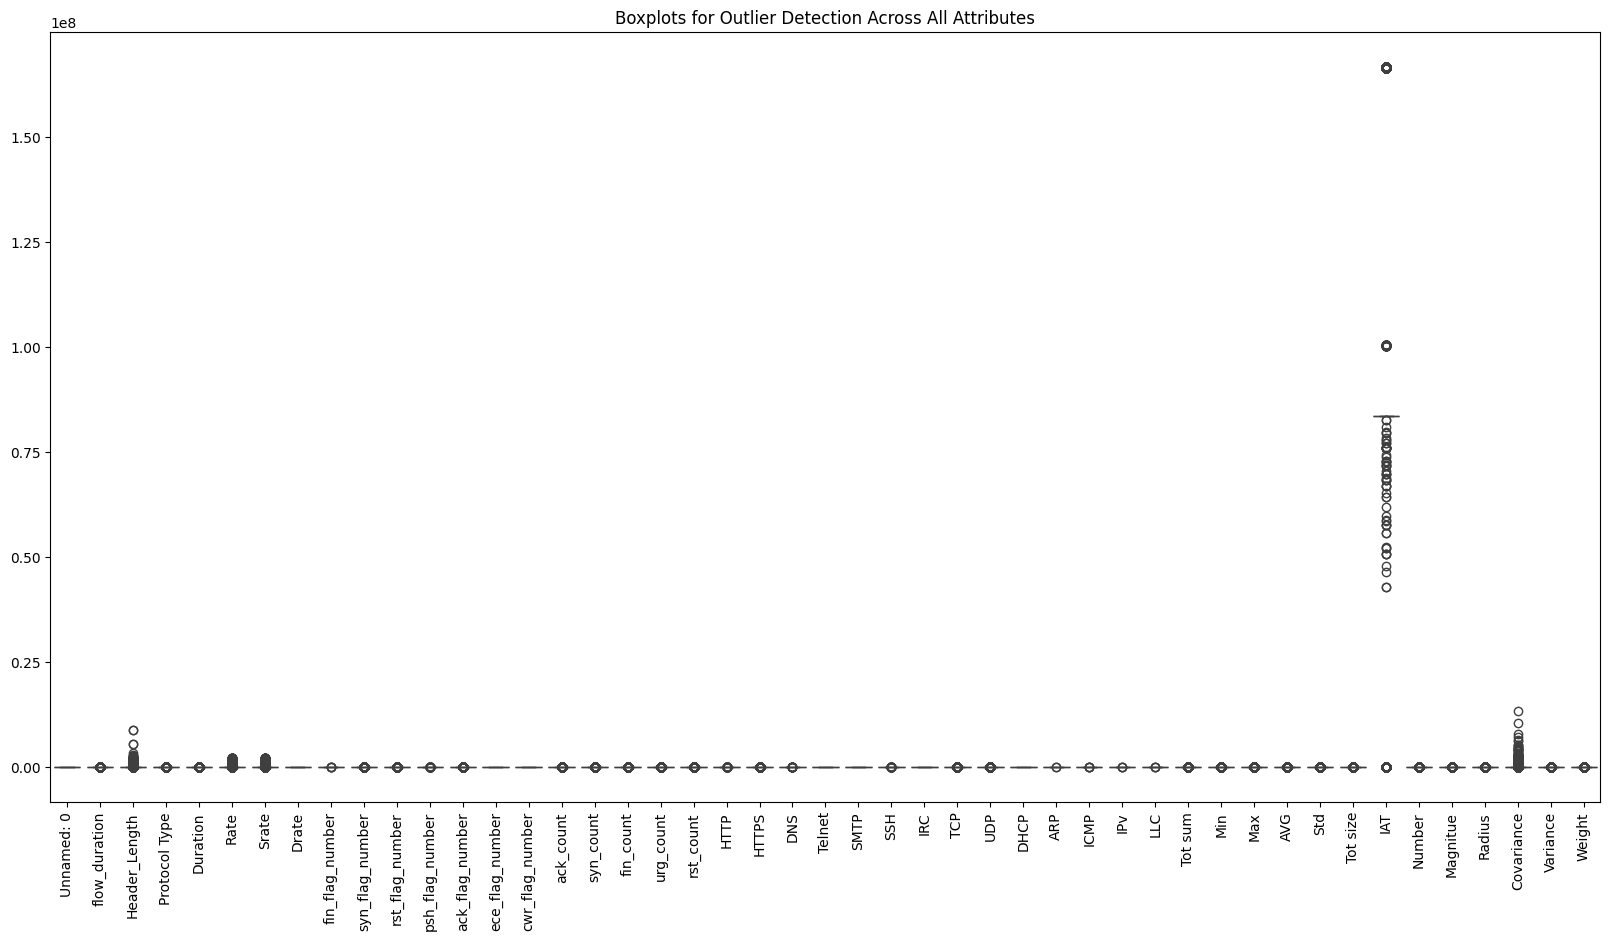

In [ ]:
# Set up the plotting area to accommodate all features
plt.figure(figsize=(20, 10))
sns.boxplot(data=iotData)  # Drop unnecessary columns for clarity

# Add titles and labels
plt.title("Boxplots for Outlier Detection Across All Attributes")
plt.xticks(rotation=90)
plt.show()